# Replication: Nguyen *et al*, 2021

## Introduction

This notebook attempts to reproduce the following paper (which already uses the [PPMI](http://ppmi-info.org) dataset):

<div class="alert alert-block alert-success">
Nguyen KP, et al. <a href=https://doi:10.1016/j.parkreldis.2021.02.026>Predicting Parkinson's disease trajectory using clinical and neuroimaging baseline measures.</a> Parkinsonism Relat Disord. 2021;85:44-51. 
</div>

This study uses data from 82 PD subjects with rs-fMRI and MDS-UPDRS total score, encompassing both motor and non-motor symptomatology at the same visit. Of these 82 subjects, 53 subjects also had scores available at year 1 after imaging, 45 at year 2, and 33 at year 4. 

The fMRI data were acquired at resting-state on 3T scanners with the same acquisition parameters. Acquisition parameters are described below (table extracted from the original paper supplementary materials).

<img src="images/acquisition.png" width=800/>

The demographics parameters for the PD patients were as follows (table extracted from the paper):

<img src="images/demographics.png" width=800/>

The main goal of this paper is to use imaging features extracted from rs-fMRI data and demographic features to train machine learning models to predict MDS-UPDRS scores of PD patients.

Imaging features includes fractional Amplitude of Low Frequency Fluctuations (fALFF) and Regional Homogeneity (ReHo) averaged for different Regions of Interest (ROI) of the brain extracted from different atlases: [100-ROI Schaefer functional brain parcellation](https://doi.org/10.1093/cercor/bhx179), modified with an additional 35 striatal and cerebellar ROIs, 197-ROI and 444-ROI versions of the [Bootstrap Analysis of Stable Clusters (BASC197) atlas](https://doi.org/10.1016/j.neuroimage.2010.02.082).

Different machine learning models were compared: ElasticNet regression, Support Vector Machine (SVM) with a linear kernel, Random Forest with a decision tree kernel, and Gradient Boosting with a decision tree kernel. 

An unbiased random search was conducted to optimize the hyperparameters of each model, including regularization strength and learning rate. To determine the best-performing parcellation, hyperparameter, and model combination for each target, a rigorous nested cross-validation approach was applied, with leave-one-out cross-validation (LOOCV) as the outer loop and 10-fold cross-validation as the inner loop.

ReHo features explained 30.4%, 45.3%, 47.1%, and 25.5% of the variance in baseline, year 1, year 2, and year 4 MDS-UPDRS score, respectively. fALFF features explained 24.2%, 55.8%, 46.3%, and 15.2% of the variance in baseline, year 1, year 2, and year 4 MDS-UPDRS score, respectively. Results were significant at p = 0.001 (false discovery rate-corrected) at all timepoints except year 4, which was significant at p = 0.05.

Results are displayed below (table extracted from the original paper). 
<img src="images/results.png" width=800/>

<br>
<details>
<summary><b>&rarr; Click me</b> to open table</summary>
     
**[Initial setup](#Initial-setup)**

**[1. Cohort selection](#Cohort-selection)**

* [1.1 Download study files](#Download-PPMI-study-files)
* [1.2 Get fMRI data information](#Get-fMRI-data-information)
* [1.3 Get clinical scores information](#Get-clinical-scores-information)
* [1.4 Replication cohort](#Replication-cohort)
* [1.5 Closest-to-original cohort](#Closest-to-original-cohort)
* [1.6 Summary of cohorts](#Summary-of-cohorts)

**[2. fMRI pre-processing](#fMRI-pre-processing)**

* [2.1 Functional pre-processing](#Functional-pre-processing)
* [2.2 Denoising](#Denoising)

**[3. ALFF/ReHo computation](#ALFF/ReHo-computation)**

**[4. Regression models training & results](#Regression-models-training-&-results)**

* [4.1 Default reproduction workflow](#Default-reproduction-workflow)
* [4.2 Reproduction workflow - replication cohort](#Reproduction-workflow-replication-cohort)
* [4.3 Comparing pre-processing pipelines](#Comparing-pre-processing-pipelines)
* [4.4 Comparing feature computation](#Comparing-feature-computation)
* [4.5 Comparing different sets of input features](#Comparing-different-sets-of-input-features)
* [4.6 Summary]

**[5. Comparing cross-validation procedures](#Comparing-cross-validation-procedures)**
     
</details>

## Initial setup

We first initialize the notebook cache and install dependencies:

In [1]:
import livingpark_utils

utils = livingpark_utils.LivingParkUtils()
utils.notebook_init()

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=RuntimeWarning)

This notebook was run on 2023-10-24 17:55:11 UTC +0000


Import necessary packages

In [2]:
# Specific study functions & constants
from nguyenetal.constants import (
    FILENAME_PARTICIPANT_STATUS,
    FILENAME_DEMOGRAPHICS,
    FILENAME_PD_HISTORY,
    FILENAME_SOCIO,
    FILENAME_AGE,
    FILENAME_MOCA,
    FILENAME_UPDRS1A,
    FILENAME_UPDRS1B,
    FILENAME_UPDRS2,
    FILENAME_UPDRS3,
    FILENAME_UPDRS3_CLEAN,
    FILENAME_UPDRS4,
    FILENAME_GDS,
    FILENAME_DOMSIDE,
    FILENAME_FMRI_INFO,
    FILENAME_FMRI_INFO_ZIP,
    FILENAME_FMRI_METADATA
)

from nguyenetal.constants import (
    COL_PAT_ID,
    COL_VISIT_TYPE,
    COL_STATUS,
    COL_PD_STATE,
    COL_AGE,
    COL_SEX,
    COL_EDUCATION,
    COL_UPDRS3,
    COL_UPDRS1A,
    COL_UPDRS1B,
    COL_UPDRS1,
    COL_UPDRS2,
    COL_UPDRS4,
    COL_MOCA,
)

from nguyenetal.constants import (
    COL_DATE_INFO,
    COL_DATE_BIRTH,
    COL_DATE_PD,
    FIELD_STRENGTH,
    STATUS_PD
    
)

from nguyenetal.constants import (
    COL_IMAGING_PROTOCOL,
    COLS_DATE, 
    IDA_STATUS_MAP,
    IDA_COLNAME_MAP,
    IDA_VISIT_MAP,
    STATUS_MED,
    ORIG_SUBLIST,
    ORIG_SESLIST
)

from nguyenetal.utils.cohort_utils import (
    load_ppmi_csv,
    get_fMRI_cohort,
    mean_impute,
    get_scores_dataframe,
    compute_summary_features,
    get_features,
    get_threshold, 
    get_outcome_measures
)

# Housetools  
from livingpark_utils.scripts import pd_status
from livingpark_utils.dataset.ppmi import disease_duration
from livingpark_utils.download.ppmi import Downloader
import ppmi_downloader

# Utils
import os

from functools import reduce
import numpy as np

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', 500)

import datetime as dt

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

This notebook was run on 2023-10-24 17:55:11 UTC +0000
This notebook was run on 2023-10-24 17:55:11 UTC +0000
Download skipped: No missing files!
File downloaded
Removed 76 records where PDSTATE=ON and EXAMTM<PDMEDTM
Number of removed records: 1
Number of removed records: 60
Number of removed records: 10
Cleaned file saved in MDS_UPDRS_Part_III_clean.csv
True


## Cohort selection

We will build a PPMI cohort that matches the one used in the original study (Table 1) as closely as possible. Our cohort will be built directly from PPMI Study Data files so that it can be replicated and updated whenever necessary.

### Download PPMI study files

We will start by downloading the PPMI Study Data files required to build our cohort: 

* Participant status (Parkinson's disease, healthy control, etc.)
* Demographics
* Age at visit
* Clinical/cognitive assessment results:
    * Montreal Cognitive Assessment (MoCA)
    * Unified Parkinson's Disease Rating Scale (UPDRS) Parts I, II and III
    * Geriatric Depression Scale (GDS)
    * Hoehn-Yahr stage

We will use the LivingPark utils library to download these files from the notebook. If files are already present in the notebook cache, they won't be downloaded again. Otherwise, a PPMI username and password are required to obtain the files. New PPMI accounts can be requested [here](http://ppmi-info.org).

In [3]:
required_files = [
    FILENAME_PARTICIPANT_STATUS,
    FILENAME_PD_HISTORY,
    FILENAME_DEMOGRAPHICS,
    FILENAME_SOCIO,
    FILENAME_AGE,
    FILENAME_MOCA,
    FILENAME_UPDRS1A,
    FILENAME_UPDRS1B,
    FILENAME_UPDRS2,
    FILENAME_UPDRS3,
    FILENAME_UPDRS4,
    FILENAME_DOMSIDE,
    FILENAME_GDS,
]

downloader = Downloader(utils.study_files_dir)
utils.get_study_files(required_files, default=downloader)

Download skipped: No missing files!


In [4]:
mri_file_name = "fMRI_info.csv"

if not os.path.exists(os.path.join(utils.study_files_dir, mri_file_name)):
    ppmi = ppmi_downloader.PPMIDownloader()
    file_name = ppmi.download_fmri_info(destination_dir=utils.study_files_dir)
    os.rename(
        os.path.join(utils.study_files_dir, file_name),
        os.path.join(utils.study_files_dir, mri_file_name),
    )

### Get fMRI data information

In [5]:
print(f"=============== fMRI cohort ===============")
df_status = load_ppmi_csv(utils, FILENAME_PARTICIPANT_STATUS)
df_fMRI_subset = get_fMRI_cohort(utils)

# cohort composition: number of PD patients/healthy controls
print(
    df_status.loc[
        df_status[COL_PAT_ID].isin(df_fMRI_subset[COL_PAT_ID]), COL_STATUS
    ].value_counts()
)

=============== fMRI cohort ===============
Using fMRI info file: /Users/egermani/Documents/nguyen-etal-2021/inputs/study_files/fMRI_info.csv
Dropping 258 subjects with non-integer IDs
Parkinson's Disease    118
Name: COHORT_DEFINITION, dtype: int64


Then, we load/compute and merge all the required clinical/cognitive measures:
* UPDRS Part I
* UPDRS Part II
* UPDRS Part III
* UPDRS Part IV
* MoCA
* GDS Score

Missing values are imputed with the mean across the entire dataset, except for the UPDRS Part III score (handled below).

There are two files associated with UPDRS Part I (IA: Complex behaviors; IB: Partipant questionnaire). We use the sum of the total score in each file.

### Get clinical scores information

In [6]:
df_cohort_assessments = get_scores_dataframe(
    utils, df_fMRI_subset
    ) 

### Replication cohort

The main cohort contains 82 participants from either the `Parkinson's Disease` or the `GenCohort PD` cohort of PPMI. These 82 participants have rs-fMRI and outcome scores at the same visit available. MDS-UPDRS scores included the Part III Motor Examination conducted on-medication. Off-medication scores were not used due to unavailability for over half of the subjects and because examinations are more practically conducted on-medication in the clinic. 

We selected participants that:
* belonged to the Parkinson's disease cohort
* had fMRI scans with same acquisition parameters as those used in the paper
* had outcome score (UPDRS) and rs-fMRI data at the same visit 

In [7]:
df_fMRI_cohort = pd.DataFrame()
for i in range(len(df_cohort_assessments)):
    df_fMRI_cohort = pd.concat([df_fMRI_cohort, 
                        df_fMRI_subset[df_fMRI_subset[COL_PAT_ID] == df_cohort_assessments.iloc[i][COL_PAT_ID]]\
                        [df_fMRI_subset[COL_VISIT_TYPE] == df_cohort_assessments.iloc[i][COL_VISIT_TYPE]]]
                        )
    
df_scores_cohort = pd.DataFrame()
for i in range(len(df_fMRI_subset)):
    df_scores_cohort = pd.concat([df_scores_cohort, 
                    df_cohort_assessments[df_cohort_assessments[COL_PAT_ID] == df_fMRI_subset.iloc[i][COL_PAT_ID]]\
                    [df_cohort_assessments[COL_VISIT_TYPE] == df_fMRI_subset.iloc[i][COL_VISIT_TYPE]]]
                    )

In [8]:
fMRI_cols_to_include = ['PATNO', 'Sex','COHORT_DEFINITION','EVENT_ID', 'INFODT', 'Age', 
                        'Description', 'Imaging Protocol', 'Image ID']
scores_cols_to_include = ['PATNO', 'EVENT_ID','PAG_NAME' ,'NP2PTOT', 'NP3TOT', 'NP1RTOT+NP1PTOT',
       'NP4TOT', 'NHY','MCATOT', 'GDS_TOTAL', 'UPDRS_TOT']

df_fMRI_cohort = df_fMRI_cohort.loc[:, fMRI_cols_to_include]
df_scores_cohort = df_scores_cohort.loc[:, scores_cols_to_include]

# Merge important columns from both datasets
df_global_cohort = df_fMRI_cohort.merge(df_scores_cohort, on=[COL_PAT_ID, COL_VISIT_TYPE])
df_global_cohort = df_global_cohort.sort_values(by=['PATNO','INFODT'])

#### Baseline timepoint

For the training, authors used the first scan & outcome score available for each participant. 

In [9]:
df_global_cohort_baseline = df_global_cohort.drop_duplicates(subset=COL_PAT_ID)
df_global_cohort_baseline = df_global_cohort_baseline[
    df_global_cohort_baseline[COL_DATE_INFO] < pd.Timestamp(2020, 1, 1, 12)
    ] # Removed due to the date of the study

In [10]:
print('Number of participants selected using papers informations:', len(df_global_cohort_baseline))

Number of participants selected using papers informations: 102


#### Predictions timepoints 

In the paper, authors are trying to predict UPDRS scores at baseline (same session as fMRI data), 1 year after, 2 years after and 4 years after. 

In [11]:
# DF with outcome scores for every participants
df_global_cohort_pred = df_cohort_assessments[df_cohort_assessments\
                                              [COL_PAT_ID].isin(df_global_cohort_baseline[COL_PAT_ID].tolist())]

# Filter by date due to the date of publication of the paper. 
df_global_cohort_pred = df_global_cohort_pred[df_global_cohort_pred[COL_DATE_INFO] < pd.Timestamp(2020, 1, 1, 12)]

# Event taken as Baseline
df_global_cohort_pred['BASELINE_EV'] = [df_global_cohort_baseline[COL_VISIT_TYPE]\
                [df_global_cohort_baseline[COL_PAT_ID] == df_global_cohort_pred[COL_PAT_ID].iloc[i]].iloc[0] \
                             for i in range(len(df_global_cohort_pred))]


In [12]:
eq_1year = {
    'BL':'V04',
    'ST':'V04',
    'V04':'V06',
    'V06':'V08',
    'V08':'V10',
    'V10':'V12'
}

eq_2year = {
    'BL':'V06',
    'ST':'V06',
    'V04':'V08',
    'V06':'V10',
    'V08':'V12',
    'V10':'V13'
}

eq_4year = {
    'BL':'V10',
    'ST':'V10',
    'V04':'V12',
    'V06':'V13',
    'V08':'V14',
    'V10':'V15'
}

In [13]:
df_global_cohort_pred['1Y_EVENT'] = [eq_1year[b] for b in df_global_cohort_pred['BASELINE_EV'].tolist()]
df_global_cohort_pred['2Y_EVENT'] = [eq_2year[b] for b in df_global_cohort_pred['BASELINE_EV'].tolist()]
df_global_cohort_pred['4Y_EVENT'] = [eq_4year[b] for b in df_global_cohort_pred['BASELINE_EV'].tolist()]

In [14]:
df_global_1y = df_global_cohort_pred[
        df_global_cohort_pred[COL_VISIT_TYPE]==df_global_cohort_pred['1Y_EVENT']
    ].drop_duplicates(subset=COL_PAT_ID)

df_global_1y = df_global_1y.merge(df_global_cohort_baseline[['PATNO','Sex']], on=['PATNO'])

df_global_2y = df_global_cohort_pred[
        df_global_cohort_pred[COL_VISIT_TYPE]==df_global_cohort_pred['2Y_EVENT']
    ].drop_duplicates(subset=COL_PAT_ID)

df_global_2y = df_global_2y.merge(df_global_cohort_baseline[['PATNO','Sex']], on=['PATNO'])

df_global_4y = df_global_cohort_pred[
        df_global_cohort_pred[COL_VISIT_TYPE]==df_global_cohort_pred['4Y_EVENT']
    ].drop_duplicates(subset=COL_PAT_ID)

df_global_4y = df_global_4y.merge(df_global_cohort_baseline[['PATNO','Sex']], on=['PATNO'])

In [15]:
print('Number of participants for 1y cohort: ', len(df_global_1y))
print('Number of participants for 2y cohort: ', len(df_global_2y))
print('Number of participants for 4y cohort: ', len(df_global_4y))

Number of participants for 1y cohort:  63
Number of participants for 2y cohort:  68
Number of participants for 4y cohort:  47


In [16]:
df_cohort_baseline = df_global_cohort_baseline
df_cohort_1y = df_global_1y
df_cohort_2y = df_global_2y
df_cohort_4y = df_global_4y

#### Extract image informations for the replication cohort

We create a dataframe with only informations regarding the images of participants for each cohort. 

In [17]:
df_fmri_cohort_baseline = df_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']]

df_fmri_cohort_1y = df_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']][
                                        df_cohort_baseline[COL_PAT_ID].isin(df_cohort_1y[COL_PAT_ID].tolist())]

df_fmri_cohort_2y = df_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']][
                                        df_cohort_baseline[COL_PAT_ID].isin(df_cohort_2y[COL_PAT_ID].tolist())]

df_fmri_cohort_4y = df_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']][
                                        df_cohort_baseline[COL_PAT_ID].isin(df_cohort_4y[COL_PAT_ID].tolist())]

In [18]:
## DOWNLOAD FMRI IMAGES

fMRI data are associated with anatomical T1 data, often necessary for preprocessing. 

We searched for the T1 data acquired during the same session as the fMRI ones for the baseline cohort. We chose the first one each time.

In [19]:
from livingpark_utils.scripts import run
from livingpark_utils.scripts import mri_metadata

run.mri_metadata()

This notebook was run on 2023-10-24 17:55:19 UTC +0000
['COR', 'Coronal', 'Cal Head 24', 'Transverse', 'tra_T1_MPRAGE', 'TRA']
['AX', 'Ax', 'axial', 'Phantom', 'T2']
{'Screening': 'SC', 'Baseline': 'BL', 'Month 6': 'V02', 'Month 12': 'V04', 'Month 24': 'V06', 'Month 36': 'V08', 'Month 48': 'V10', 'Symptomatic Therapy': 'ST', 'Unscheduled Visit 01': 'U01', 'Unscheduled Visit 02': 'U02', 'Premature Withdrawal': 'PW'}
Saved in MRI_info.csv


In [20]:
df_mri = load_ppmi_csv(utils, '3D_mri_info.csv', from_ida_search=True)

df_mri_cohort_baseline = df_mri.merge(df_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE]], 
                      on = [COL_PAT_ID, COL_VISIT_TYPE])
df_mri_cohort_baseline = df_mri_cohort_baseline.sort_values(by=[COL_PAT_ID,'Description'])
df_mri_cohort_baseline = df_mri_cohort_baseline.drop_duplicates(subset=[COL_PAT_ID])

df_mri_cohort_1y = df_mri_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']][
                                        df_mri_cohort_baseline[COL_PAT_ID].isin(df_cohort_1y[COL_PAT_ID].tolist())]

df_mri_cohort_2y = df_mri_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']][
                                        df_mri_cohort_baseline[COL_PAT_ID].isin(df_cohort_2y[COL_PAT_ID].tolist())]

df_mri_cohort_4y = df_mri_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']][
                                        df_mri_cohort_baseline[COL_PAT_ID].isin(df_cohort_4y[COL_PAT_ID].tolist())]

Dropping 3 subjects with non-integer IDs


#### Extract features for machine learning models

##### Clinical and demographics

In the paper, authors reported having used different clinical and demographic features along with the radiomic data to train the models. 
These included:
* **Clinical features**: disease duration, symptom duration, dominant symptom side, Geriatric Depression Scale (GDS), Montreal Cognitive Assessment (MoCA), and presence of tremor, rigidity, or postural instability at baseline. Baseline MDS-UPDRS score was also included as a confounding variable when training models to predict future outcomes. 
* **Demographic features**: age, sex, ethnicity, race, handedness, and years of education.

<div class="alert alert-block alert-danger">
    Dominant side is not included on PD features in the PPMI database, so we removed it from the used features.
</div>

In [21]:
df_features_cohort_baseline = get_features(df_cohort_baseline, utils,
                                  df_cohort_baseline[COL_PAT_ID].tolist(), 
                                 timepoint='baseline', add_DOMSIDE=True)

df_features_cohort_1y = get_features(df_cohort_baseline, utils,
                                  df_cohort_1y[COL_PAT_ID].tolist(), 
                                 timepoint='1y', add_DOMSIDE=True)

df_features_cohort_2y = get_features(df_cohort_baseline, utils,
                                  df_cohort_2y[COL_PAT_ID].tolist(), 
                                 timepoint='2y', add_DOMSIDE=True)

df_features_cohort_4y = get_features(df_cohort_baseline, utils,
                                  df_cohort_4y[COL_PAT_ID].tolist(), 
                                 timepoint='4y', add_DOMSIDE=True)

##### Outcome measures 

* The outcome of interest is the MDS-UPDRS total score, encompassing both motor and non-motor symptomatology. 
* As a secondary outcome measure, an MDS-UPDRS score threshold was used to dichotomize subjects into high- and low-severity groups. A threshold of 35 was selected, which was the average of the median MDS-UPDRS score at each of the four timepoints.
  
It is mentioned in the paper that there were no differences between the high- and low-severity groups in motor predominance (Part III score as a percentage of total score) at p = 0.05.


In [22]:
threshold = get_threshold(df_cohort_baseline, df_cohort_1y, df_cohort_2y, df_cohort_4y)

In [23]:
print('Threshold for replication cohort:', threshold)

Threshold for replication cohort: 36


In [24]:
df_outcome_baseline = get_outcome_measures(df_cohort_baseline, threshold)
df_outcome_1y = get_outcome_measures(df_cohort_1y, threshold)
df_outcome_2y = get_outcome_measures(df_cohort_2y, threshold)
df_outcome_4y = get_outcome_measures(df_cohort_4y, threshold)

##### Compare with original paper's cohort

In [25]:
df_allyears_summary = pd.DataFrame(columns = [('Baseline', 'Original'), ('Baseline', 'Replication'),
                                              ('Year 1', 'Original'), ('Year 1', 'Replication'), 
                                              ('Year 2', 'Original'), ('Year 2', 'Replication'), 
                                              ('Year 4', 'Original'), ('Year 4', 'Replication')])

df_allyears_summary[('Baseline', 'Original')]=['95.1','2.4','3.7','1.2','67.0','89.0','62.1 ± 9.8',
 '15.6 ± 3.0','770 ± 565','33.9 ± 15.8','-','26.7 ± 2.8','5.4 ± 1.4','1.8 ± 0.5']

df_allyears_summary[('Year 1', 'Original')] = ['94.4','1.9','5.6','0','68.5','85.2','61.9 ± 10.3',
 '15.1 ± 3.2','808 ± 576','38.0 ± 20.9','39.2 ± 21.6','26.9 ± 3.2','5.4 ± 1.6','1.8 ± 0.5']

df_allyears_summary[('Year 2', 'Original')] = ['97.8','0','4.4','0','82.2','88.9','63.6 ± 9.2',
 '15.1 ± 3.3','771 ± 506','40.2 ± 18.2','40.9 ± 18.5','26.7 ± 3.5','5.4 ± 1.2','1.8 ± 0.5']

df_allyears_summary[('Year 4', 'Original')] = ['97.0','0','3.0','0','75.8','87.9','59.5 ± 11.0',
    '15.0 ± 3.4','532 ± 346','34.9 ± 15.7','35.9 ± 16.5','27.5 ± 2.3','5.4 ± 1.7','1.7 ± 0.5']

df_allyears_summary[('Baseline', 'Replication')] = compute_summary_features(df_global_cohort_baseline, utils,
                                                                'baseline').tolist()
df_allyears_summary[('Year 1', 'Replication')] = compute_summary_features(df_global_1y, utils,
                                                                '1Y', df_global_cohort_baseline).tolist()
df_allyears_summary[('Year 2', 'Replication')] = compute_summary_features(df_global_2y, utils,
                                                                '2Y', df_global_cohort_baseline).tolist()
df_allyears_summary[('Year 4', 'Replication')] = compute_summary_features(df_global_4y, utils,
                                                                '4Y', df_global_cohort_baseline).tolist()

df_allyears_summary.index = compute_summary_features(df_global_cohort_baseline, utils,
                                                                'baseline').index

df_allyears_summary.loc['Number of subject'] = [82, len(df_global_cohort_baseline), 53, len(df_global_1y), 
                                      45, len(df_global_2y), 33, len(df_global_4y)]

df_allyears_summary.columns = pd.MultiIndex.from_tuples(df_allyears_summary.columns)
df_allyears_summary

Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!


Baseline                 \
                                            Original    Replication   
% Caucasian                                     95.1           95.1   
% African-American                               2.4            2.0   
% Asian                                          3.7            2.9   
% Hispanic                                       1.2            1.0   
% Male                                          67.0           66.7   
% right-handed                                  89.0           89.2   
Mean age, years                           62.1 ± 9.8     62.1 ± 9.5   
Mean years of education                   15.6 ± 3.0     15.6 ± 2.8   
Mean disease duration at baseline, days    770 ± 565  870.4 ± 597.1   
Mean MDS-UPDRS at baseline               33.9 ± 15.8    34.5 ± 15.6   
Mean MDS-UPDRS at timepoint                        -              -   
Mean MoCA at baseline                     26.7 ± 2.8     26.5 ± 3.0   
Mean GDS at Baseline                       5.4 ± 1.4      5.4 ± 1.4   
Mean Hoehn-Yahr stage                      1.8 ± 0.5      1.7 ± 0.5   
Number of subject                                 82            102   

                                              Year 1                 \
                                            Original    Replication   
% Caucasian                                     94.4           95.2   
% African-American                               1.9            1.6   
% Asian                                          5.6            3.2   
% Hispanic                                         0            1.6   
% Male                                          68.5           65.1   
% right-handed                                  85.2           87.3   
Mean age, years                          61.9 ± 10.3     62.5 ± 9.7   
Mean years of education                   15.1 ± 3.2     15.1 ± 2.6   
Mean disease duration at baseline, days    808 ± 576  998.3 ± 593.1   
Mean MDS-UPDRS at baseline               38.0 ± 20.9    33.7 ± 15.3   
Mean MDS-UPDRS at timepoint              39.2 ± 21.6    39.5 ± 22.2   
Mean MoCA at baseline                     26.9 ± 3.2     27.0 ± 2.9   
Mean GDS at Baseline                       5.4 ± 1.6      5.5 ± 1.7   
Mean Hoehn-Yahr stage                      1.8 ± 0.5      1.7 ± 0.5   
Number of subject                                 53             63   

                                              Year 2                 \
                                            Original    Replication   
% Caucasian                                     97.8           97.1   
% African-American                                 0            0.0   
% Asian                                          4.4            2.9   
% Hispanic                                         0            1.5   
% Male                                          82.2           76.5   
% right-handed                                  88.9           91.2   
Mean age, years                           63.6 ± 9.2     63.5 ± 9.8   
Mean years of education                   15.1 ± 3.3     15.3 ± 2.7   
Mean disease duration at baseline, days    771 ± 506  902.9 ± 566.4   
Mean MDS-UPDRS at baseline               40.2 ± 18.2    34.0 ± 15.2   
Mean MDS-UPDRS at timepoint              40.9 ± 18.5    40.7 ± 19.7   
Mean MoCA at baseline                     26.7 ± 3.5     26.9 ± 2.4   
Mean GDS at Baseline                       5.4 ± 1.2      5.5 ± 1.4   
Mean Hoehn-Yahr stage                      1.8 ± 0.5      1.8 ± 0.5   
Number of subject                                 45             68   

                                              Year 4                 
                                            Original    Replication  
% Caucasian                                     97.0           97.9  
% African-American                                 0            0.0  
% Asian                                          3.0            2.1  
% Hispanic                                         0            0.0  


The values obtained in this table are basically similar to those in the paper, except in terms of number of participants. The original baseline cohort was composed of 82 participants compared to 102 in our case. Year 1, 2 and 4 cohorts also exhibit a larger number of participants than in the original paper. 

Mean values of demographics and clinical features are similar to those of the original paper. 

To obtain the same number of participants in each cohort, we will randomly sample the same number of participants as those used in the paper and perform the replication on these participants.

In [26]:
# Verify that there were no differences between the high- and low-severity groups in motor predominance 
# (Part III score as a percentage of total score) at p = 0.05.
from scipy.stats import ttest_ind

for i, df in enumerate([df_outcome_baseline, df_outcome_1y, df_outcome_2y, df_outcome_4y]):
    df['PERC_UPDRS3'] = df['NP3TOT']/df['UPDRS_TOT']

    perc_updrs3_highsev = df['PERC_UPDRS3'][df[f'SEVERITY']==1].tolist()
    perc_updrs3_lowsev = df['PERC_UPDRS3'][df[f'SEVERITY']==0].tolist()

    if i == 0:
        time = 'Baseline'
    elif i < 3:
        time = f'{i+1} years'
    else:
        time = '4 years'
        
    print(time, ':', round(ttest_ind(perc_updrs3_highsev, perc_updrs3_lowsev)[1], 3))

Baseline : 0.128
2 years : 0.072
3 years : 0.643
4 years : 0.534


The distribution of the UPDRS-Score at Baseline and 1 year are also given in the supplementary materials. We tried to reproduce these figures. 

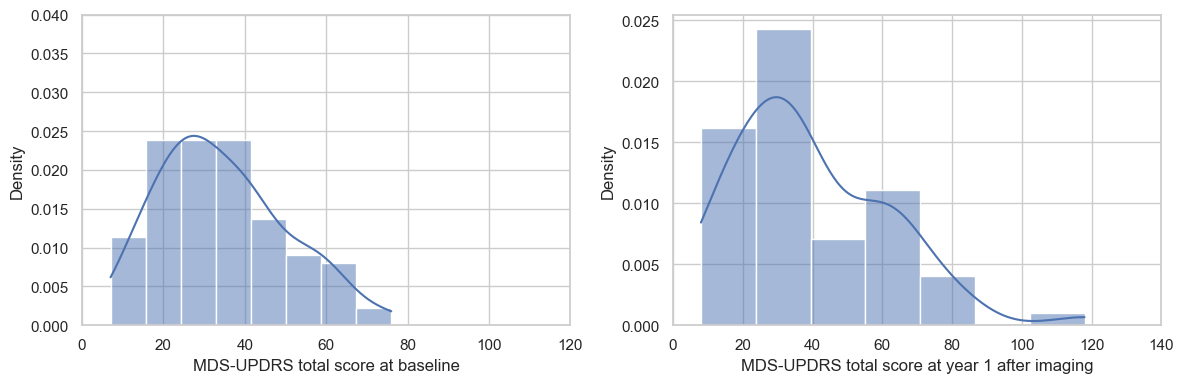

In [27]:
f = plt.figure(figsize = (12, 4))
gs = f.add_gridspec(1, 2)

ax1 = f.add_subplot(gs[0, 0])
ax1.set_xlim(0,120)
ax1.set_ylim(0, 0.04)

sns.histplot(df_outcome_baseline, x = 'UPDRS_TOT', axes=ax1, kde=True, stat='density')
ax1.set_xlabel('MDS-UPDRS total score at baseline')

ax2 = f.add_subplot(gs[0, 1])
ax2.set_xlim(0,140)
sns.histplot(df_outcome_1y,
             x = 'UPDRS_TOT', axes=ax2, kde=True, stat='density')
ax2.set_xlabel('MDS-UPDRS total score at year 1 after imaging')
plt.tight_layout()
plt.savefig('./outputs/updrs_distribution_replication_cohort.png')
plt.show()

Reported plot in the original paper are shown below. 

<img src="images/outcome_distribution.png" width=1000/>

### Closest-to-original cohort

Authors of the paper agreed to send us the participants and session list used during their experiment. We thus compared these with the cohort we gathered.

Our baseline cohort contained the 82 participants used by the authors in the original paper. However, for 5 of them, a different session was included in our cohort compared to the original one. 

#### Comparison with replication cohort

In [28]:
df_cohort_baseline_same = df_cohort_baseline.copy()

df_cohort_baseline_same['INCLUDED'] = [sub in ORIG_SUBLIST for sub in df_cohort_baseline_same['PATNO']]


ses_ymj = [ses.split('/')[-1] + '-0' + ses.split('/')[0] + '-'+ses.split('/')[1] if len(ses.split('/')[0])==1 \
           else ses.split('/')[-1] + '-' + ses.split('/')[0] + '-' + ses.split('/')[1] for ses in ORIG_SESLIST]

df_cohort_baseline_same['ORIG_SES'] = 0
df_cohort_baseline_same['ORIG_SES'][df_cohort_baseline_same['INCLUDED']==True] = ses_ymj 

df_cohort_baseline_same['CORRECT_SES'] = [
    True if str(df_cohort_baseline_same['INFODT'].tolist()[i]
               )[:10] == df_cohort_baseline_same['ORIG_SES'].tolist()[i] else False for i in range(
        len(df_cohort_baseline_same))]

correct_participants = len(df_cohort_baseline_same.loc[df_cohort_baseline_same['INCLUDED']==True])

correct_sessions = len(df_cohort_baseline_same.loc[(df_cohort_baseline_same['INCLUDED']==True) & \
                        (df_cohort_baseline_same['CORRECT_SES']==True)])

df_uncorrect_sessions = df_cohort_baseline_same.loc[(df_cohort_baseline_same['INCLUDED']==True) & \
                        (df_cohort_baseline_same['CORRECT_SES']==False)][['PATNO', 'EVENT_ID', 'INFODT', 'ORIG_SES']]

print(f'N. of original cohort participants included in reproduction cohort:', correct_participants)
print(f'N. of original cohort participants with correct session included in reproduction cohort:', correct_sessions)
print(f'Participants with uncorrect session included: \n', df_uncorrect_sessions)

N. of original cohort participants included in reproduction cohort: 82
N. of original cohort participants with correct session included in reproduction cohort: 77
Participants with uncorrect session included: 
        PATNO EVENT_ID     INFODT    ORIG_SES
14    3125.0      V06 2014-07-16  2013-07-10
105   3815.0      V06 2013-11-05  2015-11-03
157   4038.0       BL 2013-04-01  2014-09-24
160  40366.0      V06 2016-10-20  2013-04-01
165  50901.0      V06 2017-01-05  2014-12-17


In [29]:
# Why do we have different ones? 
print('Subject 3125: we used V06, authors used V04.') 
print('Missing UPDRS part III information for V04 visit. \n') 
#print(df_assessments_all.loc[(df_assessments_all['PATNO'] == 3125) & (df_assessments_all['INFODT']=='2013-07')])

print('Subject 3815: we used V06, authors used V10.')
print('To date, no explanation from the PPMI files that could explain why authors didn\'t use V06. \n')

print('Subject 4038: we used BL visit, authors used V04.')
print('To date, no explanation from the PPMI files that could explain why authors didn\'t use BL.\n')

print('Subject 40366: we used V06, we don\'t know which visit authors used.')
print('Subject 50901: we used V06, we don\'t know which visit authors used.')
print('For these two subjects, no image available before V06.')
#print(df_fMRI_subset.loc[df_fMRI_subset['PATNO'].isin([40366, 50901])])

Subject 3125: we used V06, authors used V04.
Missing UPDRS part III information for V04 visit. 

Subject 3815: we used V06, authors used V10.
To date, no explanation from the PPMI files that could explain why authors didn't use V06. 

Subject 4038: we used BL visit, authors used V04.
To date, no explanation from the PPMI files that could explain why authors didn't use BL.

Subject 40366: we used V06, we don't know which visit authors used.
Subject 50901: we used V06, we don't know which visit authors used.
For these two subjects, no image available before V06.


In [30]:
df_cohort_baseline_same = df_cohort_baseline_same.loc[df_cohort_baseline_same['INCLUDED']==True]
df_cohort_baseline_same = df_cohort_baseline_same.drop(['INCLUDED', 'ORIG_SES', 'CORRECT_SES'], axis=1)

df_cohort_1y_same = df_cohort_1y.loc[df_cohort_1y['PATNO'].isin(ORIG_SUBLIST)]
df_cohort_2y_same = df_cohort_2y.loc[df_cohort_2y['PATNO'].isin(ORIG_SUBLIST)]
df_cohort_4y_same = df_cohort_4y.loc[df_cohort_4y['PATNO'].isin(ORIG_SUBLIST)]

In [31]:
df_features_cohort_baseline_same = get_features(df_cohort_baseline_same, utils,
                                  df_cohort_baseline_same[COL_PAT_ID].tolist(), 
                                 timepoint='baseline', add_DOMSIDE=True)

df_features_cohort_1y_same = get_features(df_cohort_baseline_same, utils,
                                  df_cohort_1y_same[COL_PAT_ID].tolist(), 
                                 timepoint='1y', add_DOMSIDE=True)

df_features_cohort_2y_same = get_features(df_cohort_baseline_same, utils,
                                  df_cohort_2y_same[COL_PAT_ID].tolist(), 
                                 timepoint='2y', add_DOMSIDE=True)

df_features_cohort_4y_same = get_features(df_cohort_baseline_same, utils,
                                  df_cohort_4y_same[COL_PAT_ID].tolist(), 
                                 timepoint='4y', add_DOMSIDE=True)

We compare the demographics for this closest-to-original cohort compared to our cohort and the original papers cohort. 

In [32]:
threshold_same = get_threshold(df_cohort_baseline_same, df_cohort_1y_same, df_cohort_2y_same, df_cohort_4y_same)
print('Threshold for closest-to-original cohort:', threshold_same)

Threshold for closest-to-original cohort: 35


In [33]:
df_outcome_baseline_same = get_outcome_measures(df_cohort_baseline_same, threshold_same)
df_outcome_1y_same = get_outcome_measures(df_cohort_1y_same, threshold_same)
df_outcome_2y_same = get_outcome_measures(df_cohort_2y_same, threshold_same)
df_outcome_4y_same = get_outcome_measures(df_cohort_4y_same, threshold_same)

In [34]:
# Verify that there were no differences between the high- and low-severity groups in motor predominance 
# (Part III score as a percentage of total score) at p = 0.05.
from scipy.stats import ttest_ind

for i, df in enumerate([df_outcome_baseline_same, df_outcome_1y_same, 
                        df_outcome_2y_same, df_outcome_4y_same]):
    df['PERC_UPDRS3'] = df['NP3TOT']/df['UPDRS_TOT']

    perc_updrs3_highsev = df['PERC_UPDRS3'][df[f'SEVERITY']==1].tolist()
    perc_updrs3_lowsev = df['PERC_UPDRS3'][df[f'SEVERITY']==0].tolist()

    if i == 0:
        time = 'Baseline'
    elif i < 3:
        time = f'{i+1} years'
    else:
        time = '4 years'
        
    print(time, ':', round(ttest_ind(perc_updrs3_highsev, perc_updrs3_lowsev)[1], 3))

Baseline : 0.181
2 years : 0.076
3 years : 0.559
4 years : 0.077


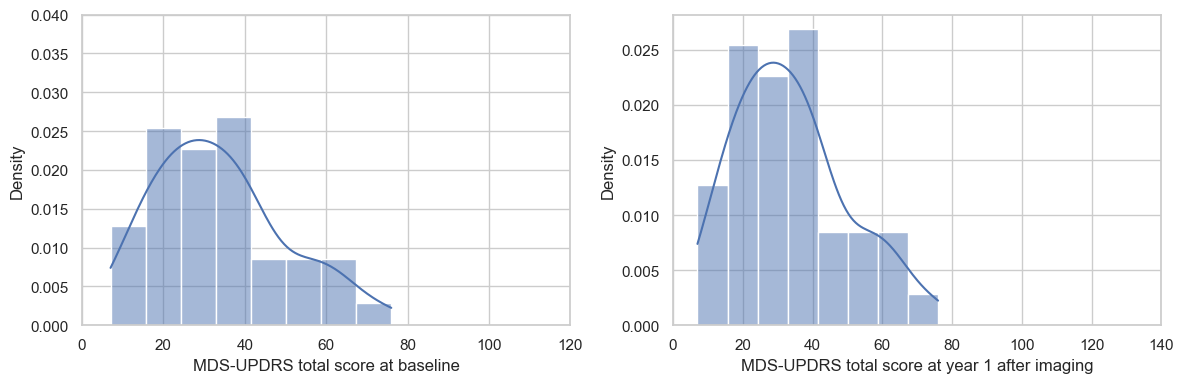

In [35]:
f = plt.figure(figsize = (12, 4))
gs = f.add_gridspec(1, 2)

ax1 = f.add_subplot(gs[0, 0])
ax1.set_xlim(0,120)
ax1.set_ylim(0, 0.04)
sns.histplot(df_outcome_baseline_same, x = 'UPDRS_TOT', axes=ax1, kde=True, stat='density')
ax1.set_xlabel('MDS-UPDRS total score at baseline')

ax2 = f.add_subplot(gs[0, 1])
ax2.set_xlim(0,140)
sns.histplot(df_outcome_baseline_same,
             x = 'UPDRS_TOT', axes=ax2, kde=True, stat='density')
ax2.set_xlabel('MDS-UPDRS total score at year 1 after imaging')

plt.tight_layout()
plt.savefig('./outputs/updrs_distribution_closest-to-original_cohort.png')
plt.show()

Reported plot in the original paper are shown below. 

<img src="images/outcome_distribution.png" width=1000/>

### Summary of cohorts

In [36]:
df_allyears_summary_cohorts = pd.DataFrame(columns = [('Baseline', 'Original'), ('Baseline', 'Replication'),
                                                      ('Baseline', 'Closest'), ('Year 1', 'Original'), 
                                                      ('Year 1', 'Replication'), ('Year 1', 'Closest'),
                                                      ('Year 2', 'Original'), ('Year 2', 'Replication'), 
                                                      ('Year 2', 'Closest'), ('Year 4', 'Original'), 
                                                      ('Year 4', 'Replication'), ('Year 4', 'Closest')])

df_allyears_summary_cohorts[('Baseline', 'Original')]=['95.1','2.4','3.7','1.2','67.0','89.0','62.1 ± 9.8',
 '15.6 ± 3.0','770 ± 565','33.9 ± 15.8','-','26.7 ± 2.8','5.4 ± 1.4','1.8 ± 0.5']

df_allyears_summary_cohorts[('Year 1', 'Original')] = ['94.4','1.9','5.6','0','68.5','85.2','61.9 ± 10.3',
 '15.1 ± 3.2','808 ± 576','38.0 ± 20.9','39.2 ± 21.6','26.9 ± 3.2','5.4 ± 1.6','1.8 ± 0.5']

df_allyears_summary_cohorts[('Year 2', 'Original')] = ['97.8','0','4.4','0','82.2','88.9','63.6 ± 9.2',
 '15.1 ± 3.3','771 ± 506','40.2 ± 18.2','40.9 ± 18.5','26.7 ± 3.5','5.4 ± 1.2','1.8 ± 0.5']

df_allyears_summary_cohorts[('Year 4', 'Original')] = ['97.0','0','3.0','0','75.8','87.9','59.5 ± 11.0',
    '15.0 ± 3.4','532 ± 346','34.9 ± 15.7','35.9 ± 16.5','27.5 ± 2.3','5.4 ± 1.7','1.7 ± 0.5']

df_allyears_summary_cohorts[('Baseline', 'Replication')] = compute_summary_features(df_global_cohort_baseline, utils,
                                                                'baseline').tolist()
df_allyears_summary_cohorts[('Year 1', 'Replication')] = compute_summary_features(df_global_1y, utils,
                                                                '1Y', df_global_cohort_baseline).tolist()
df_allyears_summary_cohorts[('Year 2', 'Replication')] = compute_summary_features(df_global_2y, utils,
                                                                '2Y', df_global_cohort_baseline).tolist()
df_allyears_summary_cohorts[('Year 4', 'Replication')] = compute_summary_features(df_global_4y, utils,
                                                                '4Y', df_global_cohort_baseline).tolist() 

df_allyears_summary_cohorts[('Baseline', 'Closest')] = compute_summary_features(df_cohort_baseline_same, utils,
                                                                'baseline').tolist()
df_allyears_summary_cohorts[('Year 1', 'Closest')] = compute_summary_features(df_cohort_1y_same, utils,
                                                                '1Y', df_cohort_baseline_same).tolist()
df_allyears_summary_cohorts[('Year 2', 'Closest')] = compute_summary_features(df_cohort_2y_same, utils,
                                                                '2Y', df_cohort_baseline_same).tolist()
df_allyears_summary_cohorts[('Year 4', 'Closest')] = compute_summary_features(df_cohort_4y_same, utils,
                                                                '4Y', df_cohort_baseline_same).tolist()

df_allyears_summary_cohorts.index = compute_summary_features(df_cohort_baseline_same, utils,
                                                                'baseline').index

df_allyears_summary_cohorts.loc['Number of subject'] = [82,  len(df_cohort_baseline), len(df_cohort_baseline_same),
                                                        53, len(df_cohort_1y), len(df_cohort_1y_same),
                                                        45, len(df_cohort_2y), len(df_cohort_2y_same), 
                                                        33, len(df_cohort_4y), len(df_cohort_4y_same)]

df_allyears_summary_cohorts.columns = pd.MultiIndex.from_tuples(df_allyears_summary_cohorts.columns)
df_allyears_summary_cohorts.to_csv('./outputs/all_cohorts_demographics.csv')

Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!


## Image pre-processing

### Functional pre-processing

In the paper, preprocessing of functional images is mentioned as below: 
- fMRI images were first realigned to the mean volume with affine transformations to correct for inter-volume head motion, using the MCFLIRT tool in FSL.
- Brain masking was performed using AFNI 3dAutomask.
- The images were next nonlinearly coregistered directly to a common EPI template in MNI space, because direct EPI spatial normalization corrects for more nonlinear magnetic susceptibility artifacts than T1-based normalization. This nonlinear normalization step was performed using the Symmetric Normalization algorithm in ANTS.

We reproduced these steps in the `Functional_Preprocessing` workflow. 

In [37]:
# from nguyenetal.workflows import func_preprocessing_wf
# from glob import glob

# pipeline = 'reproduction_pipeline-afni_seg'
# base_dir = '/srv/tempdd/egermani/nguyen-etal-2021'

# subject_list = [f.split('/')[-1].split('-')[-1] for f in glob(f'{base_dir}/inputs/data/Nifti/sub-*')]

# data_dir = f'{base_dir}/inputs/data/Nifti'
# output_dir = f'{base_dir}/outputs/{pipeline}'

# preprocessing_wf = func_preprocessing_wf.Functional_Preprocessing(data_dir, 
#                                                                 output_dir, 
#                                                                 subject_list)

# preprocessing_wf.pipeline.run()

### Denoising

After spatial preprocessing, authors mentioned the use of confounds regressors to remove the effect of movements or other signals. 
*"Because individuals with PD may exhibit substantial head motion during imaging, it is crucial to correct for head motion artifacts in fMRI data. Left uncorrected, these artifacts may introduce spurious and confounding signals into subsequent analysis. Recent work suggests that all fMRI nuisance regression should be performed simultaneously to avoid reintroduction of noise. Accordingly, motion-related regressors computed using ICA-AROMA were concatenated with the nuisance regressors from affine head motion parameters and white matter and cerebrospinal fluid, and these nuisance signals were regressed out of the fMRI data in one step"*

Affine head motion parameters are already computed during spatial preprocessing using `MCFLIRT`, but we still need to compute:
- ICA-AROMA motion-related regressors
- White matter and CSF signals 

#### ICA-AROMA

In [38]:
### WRITE STEPS FOR ICA-AROMA

#### Global signals

The computation of the global signals is not described in the paper. Thus, we implemented two different strategies to compute these signals: 
- using `AFNI` software package
- using `FSL` software package
- without anatomical priors.

In [ ]:
# from os.path import join
# from nguyenetal.workflows import anat_preprocessing_wf
# from glob import glob 

# pipeline = 'reproduction_pipeline-afni_seg'
# base_dir = '/srv/tempdd/egermani/nguyen-etal-2021'

# subject_list = [f.split('/')[-1].split('-')[-1] for f in glob(f'{base_dir}/inputs/data/Nifti/sub-*')]

# data_dir = f'{base_dir}' 

# #anat_file_template = join('inputs', 'Nifti', 'sub-{subject_id}', 'anat', 'sub-{subject_id}_T1w.nii.gz')

# func_file_template = join('outputs', f'{pipeline}', 'func_preproc', '_subject_id_{subject_id}',
#                           'sub-{subject_id}_task-rest_bold_mcf_masked_trans.nii.gz')

# output_dir=f'{base_dir}/outputs/{pipeline}'
# software='afni'

# wf = anat_preprocessing_wf.Anatomical_Preprocessing(subject_list = subject_list, 
#                                                     data_dir = data_dir, 
#                                                     func_file_template = func_file_template, 
#                                                     output_dir = output_dir, 
#                                                     software = software)

In [ ]:
# from os.path import join
# from nguyenetal.workflows import anat_preprocessing_wf
# from glob import glob 

# pipeline = 'reproduction_pipeline-fsl_seg'
# base_dir = '/srv/tempdd/egermani/nguyen-etal-2021'

# subject_list = [f.split('/')[-1].split('-')[-1] for f in glob(f'{base_dir}/inputs/data/Nifti/sub-*')]

# data_dir = f'{base_dir}' 

# #anat_file_template = join('inputs', 'Nifti', 'sub-{subject_id}', 'anat', 'sub-{subject_id}_T1w.nii.gz')

# func_file_template = join('outputs', f'{pipeline}', 'func_preproc', '_subject_id_{subject_id}',
#                           'sub-{subject_id}_task-rest_bold_mcf_masked_trans.nii.gz')

# output_dir=f'{base_dir}/outputs/{pipeline}'
# software='fsl'

# wf = anat_preprocessing_wf.Anatomical_Preprocessing(subject_list = subject_list, 
#                                                     data_dir = data_dir, 
#                                                     func_file_template = func_file_template, 
#                                                     output_dir = output_dir, 
#                                                     software = software)

In [39]:
# from os.path import join
# from nguyenetal.workflows import anat_preprocessing_wf
# from glob import glob 

# pipeline = 'reproduction_pipeline-no_anat'
# base_dir = '/srv/tempdd/egermani/nguyen-etal-2021'

# subject_list = [f.split('/')[-1].split('-')[-1] for f in glob(f'{base_dir}/inputs/data/Nifti/sub-*')]

# data_dir = f'{base_dir}' 

# #anat_file_template = join('inputs', 'Nifti', 'sub-{subject_id}', 'anat', 'sub-{subject_id}_T1w.nii.gz')

# func_file_template = join('outputs', f'{pipeline}', 'func_preproc', '_subject_id_{subject_id}',
#                           'sub-{subject_id}_task-rest_bold_mcf_masked_trans.nii.gz')

# output_dir=f'{base_dir}/outputs/{pipeline}'

# software='no-anat'

# wf = anat_preprocessing_wf.Anatomical_Preprocessing(subject_list = subject_list, 
#                                                     data_dir = data_dir, 
#                                                     func_file_template = func_file_template, 
#                                                     output_dir = output_dir, 
#                                                     software = software)

In [40]:
# wf.pipeline.run()

#### Confounds regression

Noise regression pipeline is implemented using FSL. 3 parameters files are required: 
- **Affine head motion parameters**
    - no header or index column
    - e.g. those used for input to ICA-AROMA
- **White-matter and csf signals**
    - no index column
    - header which contains `white_matter` and `csf` column ids corresponding to the signal of interest
    - e.g. those output from fmriprep or computed using `Anatomical_Preprocessing` workflow.
- **ICA-AROMA motion related regressors**
    - the computation of this file is included in the workflow, you only need to have run ICA-AROMA before (see above) and give the directory where ALL subjects ICA-AROMA outputs are stored.
    - e.g. `/outputs/ica-aroma` which contains `sub-*` directories.

In [41]:
# from glob import glob
# from nguyenetal.workflows import confound_reg_wf
# from os.path import join

# pipeline='reproduction_pipeline-afni_seg'
# base_dir = '/srv/tempdd/egermani/nguyen-etal-2021'

# data_dir=f'{base_dir}/outputs/{pipeline}'
# output_dir=f'{base_dir}/outputs/{pipeline}'

# subject_list = sorted([f.split('/')[-1].split('-')[-1] \
#                        for f in glob(f'{data_dir}/sub-*')])

# wm_csf_template= join('anat_preproc', 'sub-{subject_id}', 
#                                   'sub-{subject_id}_task-rest_desc-confounds_timeseries.tsv'
#                                  )

# motion_regressors_template = join('func_preproc','_subject_id_{subject_id}', 
#                                   'sub-{subject_id}_task-rest_bold_mcf.nii.gz.par'
#                                  )

# func_file_template = join('func_preproc', '_subject_id_{subject_id}',
#                           'sub-{subject_id}_task-rest_bold_mcf_masked_trans.nii.gz'
#                          )

# include_ICA=True
# ica_directory = f'{base_dir}/outputs/{pipeline}/ica-aroma'

# wf = confound_reg_wf.NoiseRegression_Pipeline(subject_list, data_dir, output_dir, 
#         wm_csf_template, motion_regressors_template, func_file_template,
#         include_ICA, ica_directory)

# wf.pipeline.run()

## ALFF/ReHo computation

In the paper, authors used demographic features among with imaging features to predict UPDRS-III scores. These demographic features include Regional homogeneity and fractional amplitude of low frequency fluctuations. The details of the computation are described below:

*"Regional homogeneity (ReHo) and fractional amplitude of low frequency fluctuations (fALFF) were computed from the cleaned fMRI using C-PAC. ReHo was computed using Kendall’s coefficient of concordance between each voxel and its 27-voxel neighborhood. Low frequency power was measured by applying linear detrending and bandpass filtering at 0.01–0.1 Hz to each voxel’s signal, then computing the standard deviation of the signal. This frequency band was chosen based on standard fALFF methodology and previous PD studies successfully employing similar bands. The low frequency power was divided by the standard deviation of the unfiltered signal to obtain the normalized measure, fALFF. To normalize the values, the Z-scores for ReHo and fALFF were calculated per subject."*

Here, we reproduced the pipeline used by the authors (published on [GitHub](https://github.com/DeepLearningForPrecisionHealthLab/Parkinson-Severity-rsfMRI/blob/master/ppmiutils/rsfmri.py)) to compute these two metrics at a whole-brain level. 

They used mean regional values as input to the machine learning models. These values were computed by applying an atlas parcellation on the brain images and computing the mean values per region of interest (ROI).

*"To extract regional features from the ReHo and fALFF maps, three different brain parcellations of increasing granularity were applied. These included the 100-ROI Schaefer functional brain parcellation, modified with an additional 35 striatal and cerebellar ROIs  and the 197-ROI and 444-ROI versions of the Bootstrap Analysis of Stable Clusters (BASC197) atlas. These parcellations were used to compute the mean regional ReHo or fALFF values for each subject, and the parcellation with the highest predictive value was automatically identified during subsequent hyperparameter optimization.*

For the modified Schaefer atlas, the 35 striatal and cerebellar ROIs were obtained from FSL atlases: 
- `Cerebellum-MNIfnirt-maxprob-thr25-2mm.nii.gz` for the cerebellar
- `striatum-con-label-thr25-7sub-2mm.nii.gz` for the striatum. 

In [ ]:
from boutiques.descriptor2func import function
image_processing = function("./image_processing-descriptor.json")
out = image_processing(pipeline="reproduction_pipeline-afni_seg",
	step="func",
	base_dir="/Users/egermani/Documents/nguyen-etal-2021",
	subject_list=["3107"])

print(out)

Docker version 20.10.16, build aa7e414


In [42]:
# from nguyenetal.workflows import static_measures_wf
# from glob import glob
# from os.path import join

# base_dir = '/srv/tempdd/egermani/nguyen-etal-2021'
# pipeline = 'reproduction_pipeline-afni_seg'

# subject_list = sorted([f.split('/')[-1].split('-')[-1] \
#                        for f in glob(f'{base_dir}/inputs/data/Nifti/sub-*')])

# data_dir = f'{base_dir}/outputs/{pipeline}'
# output_dir = f'{base_dir}/outputs/{pipeline}'

# func_file_template = join('denoising' ,'sub-{subject_id}',
#                           'sub-{subject_id}_task-rest_bold_mcf_masked_trans_regfilt.nii.gz')
# mask_file_template = join('func_preproc', '_subject_id_{subject_id}',
#            'sub-{subject_id}_task-rest_bold_mcf_mask_trans_mask.nii.gz')

# cereb_atlas = f'{base_dir}/inputs/atlases/Cerebellum-MNIfnirt-maxprob-thr25-2mm.nii.gz'
# striatum_atlas = f'{base_dir}/inputs/atlases/striatum-con-label-thr25-7sub-2mm.nii.gz'

# alff_reho_wf = static_measures_wf.StaticMeasures_Pipeline(subject_list, data_dir, output_dir, 
#                                                           mask_file_template, func_file_template,
#                                                           cereb_atlas, striatum_atlas,
#                                                           high_pass_filter=0.01, low_pass_filter=0.1, 
#                                                           cluster_size=27)

# alff_reho_wf.pipeline.run()

## Regression models training & results

In the paper, they mentioned that *four machine learning models of varying statistical complexity, implemented in the scikit-learn Python package, were tested for each target x feature combination: ElasticNet regression, Support Vector Machine (SVM) with a linear kernel, Random Forest with a decision tree kernel, and Gradient Boosting with a decision tree kernel. An unbiased random search was conducted to optimize the hyperparameters of each model, including regularization strength and learning rate. To determine the best-performing parcellation, hyperparameter, and model combination for each target, a rigorous nested cross-validation approach was applied, with leave-one-out cross-validation (LOOCV) as the outer loop and 10-fold cross-validation as the inner loop. Though less frequently employed in published analyses, nested cross-validation provides one of the most unbiased estimates of model performance.* 

We trained these models using the exact same code used in the paper, available on GitHub [here](https://github.com/DeepLearningForPrecisionHealthLab/Parkinson-Severity-rsfMRI/blob/master/ppmiutils/shallowmodels.py). 

### Default reproduction workflow

In [43]:
from nguyenetal.prediction import features

specific = '_same'
pipeline = 'reproduction_pipeline-afni_seg'

features_dict_same = {'baseline': get_features(df_cohort_baseline_same, utils,
                                  df_cohort_baseline_same[COL_PAT_ID].tolist(), 
                                 timepoint='baseline', add_DOMSIDE=True),
                         '1y':get_features(df_cohort_baseline_same, utils,
                                  df_cohort_1y_same[COL_PAT_ID].tolist(), 
                                 timepoint='1y', add_DOMSIDE=True),
                         '2y':get_features(df_cohort_baseline_same, utils,
                                  df_cohort_2y_same[COL_PAT_ID].tolist(), 
                                 timepoint='2y', add_DOMSIDE=True), 
                         '4y':get_features(df_cohort_baseline_same, utils,
                                  df_cohort_4y_same[COL_PAT_ID].tolist(), 
                                 timepoint='4y', add_DOMSIDE=True)}

outcome_dict_same = {'baseline': get_outcome_measures(df_cohort_baseline_same, threshold), 
                '1y': get_outcome_measures(df_cohort_1y_same, threshold), 
                '2y': get_outcome_measures(df_cohort_2y_same, threshold),
                '4y': get_outcome_measures(df_cohort_4y_same, threshold)}

#features.save_features(pipeline, features_dict_same, outcome_dict_same, specific=specific)

In [44]:
pipeline = 'reproduction_pipeline-afni_seg'
specific = '_same'

#train_model.train_ml_models(pipeline, specific)

#### Results
For each trained model at each timepoint with each atlas, we do a Leave One Out Cross-Validation, i.e.:
1. we split the dataset in TRAIN/TEST with TEST being only ONE participant
2. we search for the parameters of the model that performed best on VALID set (10-fold CV on the TRAIN set)
3. we apply this model on the TEST set and report results.

At this point, we obtain a dataframe with the results obtained in VALIDATION: each row consists in a set of model x hyperparameters x parcellation and a train-valid/test fold. 

For each test fold, we search for the model that had the best performance on the 10-fold cross-validation. This model is selected and results computed on the TEST fold. 

In [45]:
from nguyenetal.results import results

specific = '_same'
pipeline = 'reproduction_pipeline-afni_seg'

# for timepoint in ['baseline', '1y', '2y', '4y']:
#     for feature in ['zfalff', 'zReHo', 'zalff', 'ReHo', 'falff']:
#         cv_df = results.cross_validation_results(pipeline, feature, timepoint, specific)

#         if specific==None:         
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}_cross-validation_results.csv')
#         else: 
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}{specific}_cross-validation_results.csv')

In [46]:
original_df = './images/original_results.csv'

results.plot_results_table(pipeline, 
                           original_df_file = original_df, 
                           feature_list = ['zfalff', 'zReHo'],
                           specific = specific, 
                           display='best')

,MDS-UPDRS Prediction target,Feature,Type,Best performing model,Best performing parcellation,R2,RMSE,AUC,PPV,NPV,Spec.,Sens.
1,Baseline,fALFF,Original,Gradient Boosting,Schaefer,0.242,14.006,0.668,60.0%,74.0%,75.5%,58.1%
0,Baseline,fALFF,Replication,Gradient Boosting,BASC197,0.170,14.590,0.584,51.7%,66.0%,71.4%,45.5%
0,Baseline,ReHo,Original,Gradient Boosting,Schaefer,0.304,13.415,0.674,59.4%,75.0%,73.5%,61.3%
0,Baseline,ReHo,Replication,ElasticNet,BASC444,0.117,15.050,0.635,55.9%,70.8%,69.4%,57.6%
3,Year 1,fALFF,Original,ElasticNet,Schaefer,0.558,14.256,0.753,70.4%,80.0%,71.4%,79.2%
0,Year 1,fALFF,Replication,Gradient Boosting,BASC444,0.537,15.350,0.752,71.4%,79.2%,70.4%,80.0%
2,Year 1,ReHo,Original,ElasticNet,Schaefer,0.453,15.861,0.753,70.4%,80.0%,71.4%,79.2%
0,Year 1,ReHo,Replication,Random Forest,Schaefer,0.452,16.700,0.824,86.4%,80.0%,88.9%,76.0%
5,Year 2,fALFF,Original,ElasticNet,Schaefer,0.463,13.426,0.765,78.6%,76.5%,68.4%,84.6%
0,Year 2,fALFF,Replication,Random Forest,BASC197,0.276,17.350,0.581,64.9%,52.6%,43.5%,72.7%


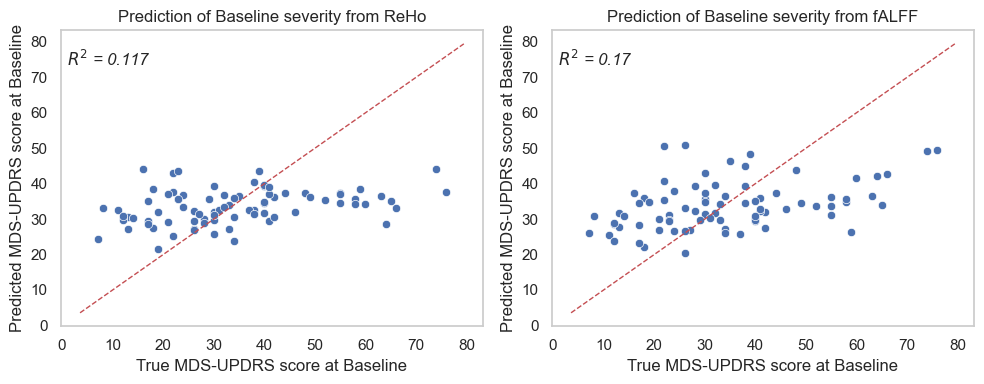

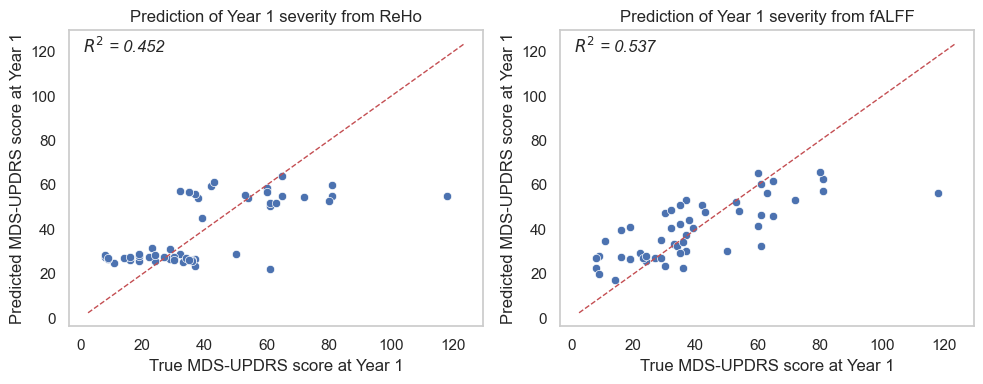

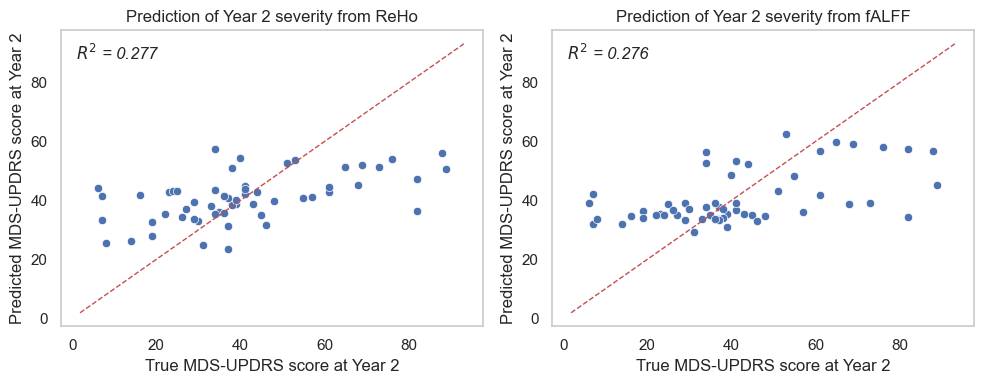

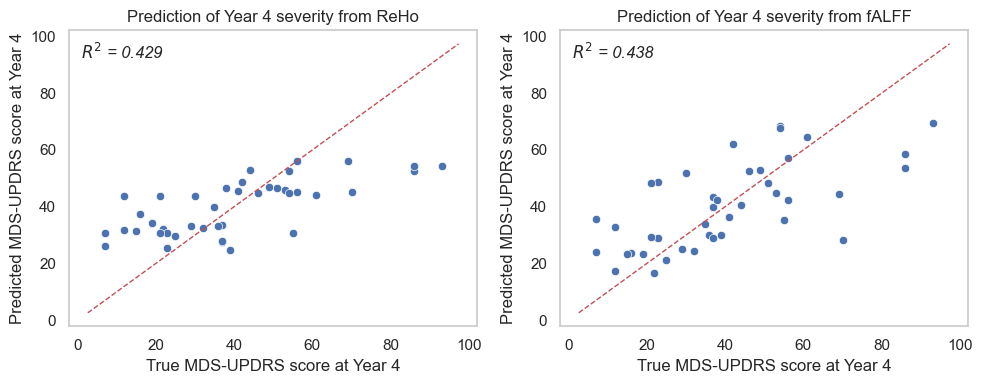

In [47]:
specific = '_same'
pipeline = 'reproduction_pipeline-afni_seg'
original_df = './images/original_results.csv'

global_df = results.plot_results_table(pipeline, 
                                       original_df_file = original_df, 
                                       specific = specific, 
                                       display='best')

results.plot_pred_real(pipeline, global_df, specific='_same', 
                       feature_list = ['zReHo', 'zfalff'])

#### Summary results with closest-to-original cohort

In [48]:
specific = '_same'
pipeline = 'reproduction_pipeline-afni_seg'
original_df = './images/original_results.csv'

global_df = results.plot_results_table(pipeline, 
                                       original_df_file = original_df, 
                                       specific = specific, 
                                       display='all')

df_reproduction_performance = pd.DataFrame()
df_reproduction_performance['Min. performance'] = global_df.groupby(['MDS-UPDRS Prediction target', 'Feature','Type'])['R2'].min()
df_reproduction_performance['Max. performance'] = global_df.groupby(['MDS-UPDRS Prediction target', 'Feature','Type'])['R2'].max()
df_reproduction_performance['Average performance'] = global_df.groupby(['MDS-UPDRS Prediction target', 'Feature','Type'])['R2'].mean()
df_reproduction_performance['standard deviation'] = global_df.groupby(['MDS-UPDRS Prediction target', 'Feature','Type'])['R2'].std()


df_reproduction_performance = df_reproduction_performance.round(3)
df_reproduction_performance.to_csv('./outputs/reproduction_pipeline-afni_seg/figures/performance_reproduction-pipeline'+\
                                   '_same-cohort_zscore-fALFF_all-inputs_code-based.csv')

In [49]:
specific = '_same'
pipeline = 'reproduction_pipeline-afni_seg'
original_df = './images/original_results.csv'

global_df = results.plot_results_table(pipeline, 
                                       original_df_file = original_df, 
                                       specific = specific, 
                                       display='all')

df_all_models = pd.DataFrame(columns=[('MDS-UPDRS Prediction target',''), ('Feature',''), ('Type','')])

for model in ['ElasticNet', 'SVM','Gradient Boosting', 'Random Forest']:
    for atlas in ['Schaefer', 'BASC197', 'BASC444']:
        df_all_models[(model, atlas)]=[]

df_all_models.columns = pd.MultiIndex.from_tuples(df_all_models.columns)

for timepoint in ['Baseline', 'Year 1', 'Year 2', 'Year 4']:
    for feature in ['fALFF', 'ReHo']:
        for type in ['Original', 'Replication']:
            sub_dict = {}
            sub_dict[('MDS-UPDRS Prediction target','')] = timepoint
            sub_dict[('Feature','')] = feature
            sub_dict[('Type','')]=type
            
            for col in df_all_models.columns.tolist()[3:]:
                sub_dict[col]=global_df['R2'].loc[(global_df['MDS-UPDRS Prediction target'] == timepoint) &\
                                                    (global_df['Feature']==feature) &\
                                                    (global_df['Type']==type) &\
                                                    (global_df['Best performing model'] == str(col[0])) &\
                                                    (global_df['Best performing parcellation'] == str(col[1]))].tolist()

                if len(sub_dict[col])==0:
                    sub_dict[col]= ''
                else:
                    sub_dict[col]=[round(sub_dict[col][0],3)]

            sub_df = pd.DataFrame(sub_dict)
            df_all_models = pd.concat([df_all_models, sub_df])

df_all_models.to_csv('./outputs/reproduction_pipeline-afni_seg/figures/performance_reproduction-pipeline'+\
                        '_same-cohort_zscore-fALFF_all-inputs_code-based_all-models.csv')        

### Reproduction workflow - Replication cohort 

In [50]:
import pandas as pd
import os
from nguyenetal.prediction import features

pipeline = 'reproduction_pipeline-afni_seg'
specific = None

features_dict = {'baseline': df_features_cohort_baseline, 
                '1y': df_features_cohort_1y, 
                '2y': df_features_cohort_2y,
                '4y': df_features_cohort_4y}

outcome_dict = {'baseline': df_outcome_baseline, 
                '1y': df_outcome_1y, 
                '2y': df_outcome_2y,
                '4y': df_outcome_4y}

# features.save_features(pipeline, features_dict, outcome_dict, specific=specific)

In [51]:
from nguyenetal.prediction import train_model
import pandas as pd
import numpy as np

pipeline = 'reproduction_pipeline-afni_seg'
specific = None

#train_model.train_ml_models(pipeline, specific)

In [52]:
from nguyenetal.results import results

pipeline = 'reproduction_pipeline-afni_seg'
specific = None

# for timepoint in ['baseline']:
#     for feature in ['zfalff', 'zReHo']:
#         cv_df = results.cross_validation_results(pipeline, feature, timepoint, specific)
        
#         if not specific:         
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}_cross-validation_results.csv')
#         else: 
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}{specific}_cross-validation_results.csv')

Table 2. of the paper report the prediction results for the different timepoints and features. 
Results are averaged across LOOCV folds, meaning that 

In [122]:
pipeline = 'reproduction_pipeline-afni_seg'
specific = None
original_df = './images/original_results.csv'

global_df = results.plot_results_table(pipeline, 
                                       feature_list = ['zfalff', 'zReHo'],
                                       original_df_file = None, 
                                       specific = specific, 
                                       display='best')

global_df.set_index(['MDS-UPDRS Prediction target', 'Feature','Type'])

Best performing model  \
MDS-UPDRS Prediction target Feature Type                                
Baseline                    fALFF   Replication     Gradient Boosting   
                            ReHo    Replication     Gradient Boosting   
Year 1                      fALFF   Replication            ElasticNet   
                            ReHo    Replication            ElasticNet   
Year 2                      fALFF   Replication     Gradient Boosting   
                            ReHo    Replication         Random Forest   
Year 4                      fALFF   Replication     Gradient Boosting   
                            ReHo    Replication     Gradient Boosting   

                                                Best performing parcellation  \
MDS-UPDRS Prediction target Feature Type                                       
Baseline                    fALFF   Replication                      BASC444   
                            ReHo    Replication                     Schaefer   
Year 1                      fALFF   Replication                      BASC197   
                            ReHo    Replication                     Schaefer   
Year 2                      fALFF   Replication                     Schaefer   
                            ReHo    Replication                     Schaefer   
Year 4                      fALFF   Replication                      BASC197   
                            ReHo    Replication                     Schaefer   

                                                    R2   RMSE    AUC    PPV  \
MDS-UPDRS Prediction target Feature Type                                      
Baseline                    fALFF   Replication  0.077  14.92  0.579  50.0%   
                            ReHo    Replication  0.107  14.68  0.618  55.8%   
Year 1                      fALFF   Replication  0.449  16.33  0.706  63.4%   
                            ReHo    Replication  0.477  15.90  0.720  65.8%   
Year 2                      fALFF   Replication  0.313  16.23  0.650  72.7%   
                            ReHo    Replication  0.307  16.30  0.612  69.6%   
Year 4                      fALFF   Replication  0.431  16.15  0.782  81.2%   
                            ReHo    Replication  0.352  17.24  0.695  77.8%   

                                                   NPV  Spec.  Sens.  
MDS-UPDRS Prediction target Feature Type                              
Baseline                    fALFF   Replication  65.4%  57.6%  58.1%  
                            ReHo    Replication  67.8%  67.8%  55.8%  
Year 1                      fALFF   Replication  81.8%  54.5%  86.7%  
                            ReHo    Replication  80.0%  60.6%  83.3%  
Year 2                      fALFF   Replication  58.3%  53.8%  76.2%  
                            ReHo    Replication  54.5%  46.2%  76.2%  
Year 4                      fALFF   Replication  80.0%  66.7%  89.7%  
                            ReHo    Replication  60.0%  66.7%  72.4%

In [54]:
#results.plot_pred_real(pipeline, global_df)

In [55]:
#from nguyenetal.results import feature_importance

#feature_importance.plot_all_feature_importance(global_df, pipeline, specific=None)

### Comparing pre-processing pipelines

#### Reproduction pipeline FSL segmentation

In [72]:
specific = '_same' 
pipeline = 'reproduction_pipeline-fsl_seg'

#features.save_features(pipeline, features_dict_same, outcome_dict_same, specific=specific)

#train_model.train_ml_models(pipeline, specific)

In [73]:
specific = '_same' 
pipeline = 'reproduction_pipeline-fsl_seg'

# for timepoint in ['baseline', '1y', '2y', '4y']:
#     for feature in ['zfalff', 'zReHo']:
        
#         cv_df = results.cross_validation_results(pipeline, feature, timepoint, specific)

#         if specific==None:         
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}_cross-validation_results.csv')
#         else: 
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}{specific}_cross-validation_results.csv')

In [74]:
specific = '_same' 
pipeline = 'reproduction_pipeline-fsl_seg'
original_df = './images/original_results.csv'

df_fsl = results.plot_results_table(pipeline, 
                                       original_df_file = None, 
                                       specific = specific, 
                                       display='best')

df_fsl.set_index(['MDS-UPDRS Prediction target', 'Feature','Type'])

Best performing model  \
MDS-UPDRS Prediction target Feature Type                                
Baseline                    fALFF   Replication     Gradient Boosting   
                            ReHo    Replication         Random Forest   
Year 1                      fALFF   Replication     Gradient Boosting   
                            ReHo    Replication         Random Forest   
Year 2                      fALFF   Replication         Random Forest   
                            ReHo    Replication            ElasticNet   
Year 4                      fALFF   Replication     Gradient Boosting   
                            ReHo    Replication            ElasticNet   

                                                Best performing parcellation  \
MDS-UPDRS Prediction target Feature Type                                       
Baseline                    fALFF   Replication                      BASC197   
                            ReHo    Replication                      BASC444   
Year 1                      fALFF   Replication                      BASC444   
                            ReHo    Replication                     Schaefer   
Year 2                      fALFF   Replication                      BASC197   
                            ReHo    Replication                      BASC197   
Year 4                      fALFF   Replication                      BASC197   
                            ReHo    Replication                      BASC197   

                                                    R2   RMSE    AUC    PPV  \
MDS-UPDRS Prediction target Feature Type                                      
Baseline                    fALFF   Replication  0.124  14.99  0.539  45.2%   
                            ReHo    Replication  0.127  14.96  0.711  69.0%   
Year 1                      fALFF   Replication  0.523  15.58  0.809  77.8%   
                            ReHo    Replication  0.460  16.58  0.824  86.4%   
Year 2                      fALFF   Replication  0.247  17.70  0.594  66.7%   
                            ReHo    Replication  0.284  17.25  0.650  68.2%   
Year 4                      fALFF   Replication  0.518  14.69  0.749  79.2%   
                            ReHo    Replication  0.424  16.06  0.669  72.0%   

                                                   NPV  Spec.  Sens.  
MDS-UPDRS Prediction target Feature Type                              
Baseline                    fALFF   Replication  62.7%  65.3%  42.4%  
                            ReHo    Replication  75.5%  81.6%  60.6%  
Year 1                      fALFF   Replication  84.0%  77.8%  84.0%  
                            ReHo    Replication  80.0%  88.9%  76.0%  
Year 2                      fALFF   Replication  52.2%  52.2%  66.7%  
                            ReHo    Replication  75.0%  39.1%  90.9%  
Year 4                      fALFF   Replication  70.6%  70.6%  79.2%  
                            ReHo    Replication  62.5%  58.8%  75.0%

#### Reproduction pipeline without any anatomical prior

In [75]:
specific = '_same' 
pipeline = 'reproduction_pipeline-no_anat'

#features.save_features(pipeline, features_dict_same, outcome_dict_same, specific=specific)

#train_model.train_ml_models(pipeline, specific)

In [76]:
specific = '_same' 
pipeline = 'reproduction_pipeline-no_anat'

# for timepoint in ['baseline', '1y', '2y', '4y']:
#     for feature in ['zfalff', 'zReHo']:
#         cv_df = results.cross_validation_results(pipeline, feature, timepoint, specific)

#         if specific==None:         
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}_cross-validation_results.csv')
#         else: 
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}{specific}_cross-validation_results.csv')

In [77]:
specific = '_same' 
pipeline = 'reproduction_pipeline-no_anat'
original_df = './images/original_results.csv'

df_no_anat = results.plot_results_table(pipeline, 
                                       original_df_file = None, 
                                       specific = specific, 
                                       display='best')

df_no_anat.set_index(['MDS-UPDRS Prediction target', 'Feature','Type'])

Best performing model  \
MDS-UPDRS Prediction target Feature Type                                
Baseline                    fALFF   Replication     Gradient Boosting   
                            ReHo    Replication     Gradient Boosting   
Year 1                      fALFF   Replication     Gradient Boosting   
                            ReHo    Replication         Random Forest   
Year 2                      fALFF   Replication     Gradient Boosting   
                            ReHo    Replication            ElasticNet   
Year 4                      fALFF   Replication            ElasticNet   
                            ReHo    Replication     Gradient Boosting   

                                                Best performing parcellation  \
MDS-UPDRS Prediction target Feature Type                                       
Baseline                    fALFF   Replication                      BASC197   
                            ReHo    Replication                      BASC444   
Year 1                      fALFF   Replication                      BASC444   
                            ReHo    Replication                     Schaefer   
Year 2                      fALFF   Replication                      BASC197   
                            ReHo    Replication                     Schaefer   
Year 4                      fALFF   Replication                     Schaefer   
                            ReHo    Replication                      BASC444   

                                                    R2   RMSE    AUC    PPV  \
MDS-UPDRS Prediction target Feature Type                                      
Baseline                    fALFF   Replication  0.023  15.84  0.548  45.0%   
                            ReHo    Replication -0.013  16.12  0.610  55.2%   
Year 1                      fALFF   Replication  0.451  16.73  0.752  71.4%   
                            ReHo    Replication  0.438  16.91  0.824  86.4%   
Year 2                      fALFF   Replication  0.366  16.24  0.735  77.1%   
                            ReHo    Replication  0.308  16.96  0.657  69.0%   
Year 4                      fALFF   Replication  0.468  15.44  0.681  71.4%   
                            ReHo    Replication  0.514  14.75  0.808  86.4%   

                                                   NPV  Spec.  Sens.  
MDS-UPDRS Prediction target Feature Type                              
Baseline                    fALFF   Replication  64.3%  55.1%  54.5%  
                            ReHo    Replication  67.9%  73.5%  48.5%  
Year 1                      fALFF   Replication  79.2%  70.4%  80.0%  
                            ReHo    Replication  80.0%  88.9%  76.0%  
Year 2                      fALFF   Replication  71.4%  65.2%  81.8%  
                            ReHo    Replication  71.4%  43.5%  87.9%  
Year 4                      fALFF   Replication  69.2%  52.9%  83.3%  
                            ReHo    Replication  73.7%  82.4%  79.2%

#### fMRIprep preprocessing

In [81]:
specific = '_same' 
pipeline = 'fmriprep_pipeline'

#features.save_features(pipeline, features_dict_same, outcome_dict_same, specific=specific)

#train_model.train_ml_models(pipeline, specific)

In [82]:
specific = '_same' 
pipeline = 'fmriprep_pipeline'

# for timepoint in ['baseline', '1y', '2y', '4y']:
#     for feature in ['zfalff', 'zReHo']:
        
#         cv_df = results.cross_validation_results(pipeline, feature, timepoint, specific)

#         if specific==None:         
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}_cross-validation_results.csv')
#         else: 
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}{specific}_cross-validation_results.csv')

In [83]:
specific = '_same' 
pipeline = 'fmriprep_pipeline'
original_df = './images/original_results.csv'

global_df = results.plot_results_table(pipeline, 
                                       original_df_file = None, 
                                       specific = specific, 
                                       display='best')

global_df.set_index(['MDS-UPDRS Prediction target', 'Feature','Type'])

Best performing model  \
MDS-UPDRS Prediction target Feature Type                                
Baseline                    fALFF   Replication     Gradient Boosting   
                            ReHo    Replication            ElasticNet   
Year 1                      fALFF   Replication     Gradient Boosting   
                            ReHo    Replication            ElasticNet   
Year 2                      fALFF   Replication     Gradient Boosting   
                            ReHo    Replication         Random Forest   
Year 4                      fALFF   Replication            ElasticNet   
                            ReHo    Replication     Gradient Boosting   

                                                Best performing parcellation  \
MDS-UPDRS Prediction target Feature Type                                       
Baseline                    fALFF   Replication                      BASC444   
                            ReHo    Replication                      BASC444   
Year 1                      fALFF   Replication                      BASC197   
                            ReHo    Replication                      BASC444   
Year 2                      fALFF   Replication                     Schaefer   
                            ReHo    Replication                      BASC197   
Year 4                      fALFF   Replication                      BASC197   
                            ReHo    Replication                     Schaefer   

                                                    R2   RMSE    AUC    PPV  \
MDS-UPDRS Prediction target Feature Type                                      
Baseline                    fALFF   Replication -0.035  16.30  0.554  46.9%   
                            ReHo    Replication  0.089  15.29  0.635  55.9%   
Year 1                      fALFF   Replication  0.475  16.35  0.695  65.5%   
                            ReHo    Replication  0.487  16.17  0.773  71.0%   
Year 2                      fALFF   Replication  0.322  16.79  0.655  70.3%   
                            ReHo    Replication  0.228  17.92  0.585  63.8%   
Year 4                      fALFF   Replication  0.321  17.45  0.732  75.0%   
                            ReHo    Replication  0.400  16.39  0.799  83.3%   

                                                   NPV  Spec.  Sens.  
MDS-UPDRS Prediction target Feature Type                              
Baseline                    fALFF   Replication  64.0%  65.3%  45.5%  
                            ReHo    Replication  70.8%  69.4%  57.6%  
Year 1                      fALFF   Replication  73.9%  63.0%  76.0%  
                            ReHo    Replication  85.7%  66.7%  88.0%  
Year 2                      fALFF   Replication  63.2%  52.2%  78.8%  
                            ReHo    Replication  66.7%  26.1%  90.9%  
Year 4                      fALFF   Replication  76.9%  58.8%  87.5%  
                            ReHo    Replication  76.5%  76.5%  83.3%

### Comparing feature computation 

#### Not z-scoring feature images

In [84]:
from nguyenetal.prediction import features
specific = '_same' 
pipeline = 'reproduction_pipeline-afni_seg'

#features.save_features(pipeline, features_dict, outcome_dict, specific=specific)

#train_model.train_ml_models(pipeline, specific)

In [85]:
specific = '_same'
pipeline = 'reproduction_pipeline-afni_seg'

# for timepoint in ['baseline', '1y', '2y', '4y']:
#     for feature in ['falff', 'ReHo']:
        
#         cv_df = results.cross_validation_results(pipeline, feature, timepoint, specific)

#         if specific==None:         
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}_cross-validation_results.csv')
#         else: 
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}{specific}_cross-validation_results.csv')

In [86]:
specific = '_same'
pipeline = 'reproduction_pipeline-afni_seg'

global_df = results.plot_results_table(pipeline, 
                                       feature_list = ['falff', 'ReHo'],
                                       original_df_file = None, 
                                       specific = specific, 
                                       display='best')

global_df.set_index(['MDS-UPDRS Prediction target', 'Feature','Type'])

Best performing model  \
MDS-UPDRS Prediction target Feature Type                                
Baseline                    fALFF   Replication         Random Forest   
                            ReHo    Replication     Gradient Boosting   
Year 1                      fALFF   Replication         Random Forest   
                            ReHo    Replication            ElasticNet   
Year 2                      fALFF   Replication         Random Forest   
                            ReHo    Replication     Gradient Boosting   
Year 4                      fALFF   Replication            ElasticNet   
                            ReHo    Replication            ElasticNet   

                                                Best performing parcellation  \
MDS-UPDRS Prediction target Feature Type                                       
Baseline                    fALFF   Replication                      BASC444   
                            ReHo    Replication                     Schaefer   
Year 1                      fALFF   Replication                     Schaefer   
                            ReHo    Replication                     Schaefer   
Year 2                      fALFF   Replication                     Schaefer   
                            ReHo    Replication                      BASC444   
Year 4                      fALFF   Replication                      BASC444   
                            ReHo    Replication                      BASC197   

                                                    R2   RMSE    AUC    PPV  \
MDS-UPDRS Prediction target Feature Type                                      
Baseline                    fALFF   Replication -0.007  16.08  0.508  41.2%   
                            ReHo    Replication  0.327  13.14  0.802  74.3%   
Year 1                      fALFF   Replication  0.422  17.16  0.824  86.4%   
                            ReHo    Replication  0.513  15.75  0.695  65.5%   
Year 2                      fALFF   Replication  0.240  17.78  0.629  71.4%   
                            ReHo    Replication  0.262  17.52  0.677  72.2%   
Year 4                      fALFF   Replication  0.376  16.73  0.761  77.8%   
                            ReHo    Replication  0.456  15.61  0.778  82.6%   

                                                   NPV  Spec.  Sens.  
MDS-UPDRS Prediction target Feature Type                              
Baseline                    fALFF   Replication  60.4%  59.2%  42.4%  
                            ReHo    Replication  85.1%  81.6%  78.8%  
Year 1                      fALFF   Replication  80.0%  88.9%  76.0%  
                            ReHo    Replication  73.9%  63.0%  76.0%  
Year 2                      fALFF   Replication  53.6%  65.2%  60.6%  
                            ReHo    Replication  65.0%  56.5%  78.8%  
Year 4                      fALFF   Replication  78.6%  64.7%  87.5%  
                            ReHo    Replication  72.2%  76.5%  79.2%

#### ALFF instead of fALFF

In [88]:
from nguyenetal.prediction import features
specific = '_same' 
pipeline = 'reproduction_pipeline-afni_seg'

#features.save_features(pipeline, features_dict, outcome_dict, specific=specific)

#train_model.train_ml_models(pipeline, specific)

In [89]:
specific = '_same'
pipeline = 'reproduction_pipeline-afni_seg'

# for timepoint in ['baseline', '1y', '2y', '4y']:
#     for feature in ['zalff']:
        
#         cv_df = results.cross_validation_results(pipeline, feature, timepoint, specific)

#         if specific==None:         
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}_cross-validation_results.csv')
#         else: 
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}{specific}_cross-validation_results.csv')

In [90]:
specific = '_same'
pipeline = 'reproduction_pipeline-afni_seg'

global_df = results.plot_results_table(pipeline, 
                                       feature_list = ['zalff'],
                                       original_df_file = None, 
                                       specific = specific, 
                                       display='best')

global_df.set_index(['MDS-UPDRS Prediction target', 'Feature','Type'])

,,,Best performing model,Best performing parcellation,R2,RMSE,AUC,PPV,NPV,Spec.,Sens.
MDS-UPDRS Prediction target,Feature,Type,,,,,,,,,
Baseline,fALFF,Replication,Gradient Boosting,BASC444,0.221,14.14,0.711,64.7%,77.1%,75.5%,66.7%
Year 1,fALFF,Replication,ElasticNet,Schaefer,0.445,16.82,0.807,80.0%,81.5%,81.5%,80.0%
Year 2,fALFF,Replication,ElasticNet,BASC197,0.160,18.69,0.540,61.4%,50.0%,26.1%,81.8%
Year 4,fALFF,Replication,Random Forest,Schaefer,0.271,18.07,0.607,68.2%,52.6%,58.8%,62.5%


### Comparing different sets of input features 

#### Reproduction pipeline - Only imaging features

In [94]:
from nguyenetal.prediction import features

specific = '_same_only-imaging' 
pipeline = 'reproduction_pipeline-afni_seg'

#features.save_features(pipeline, features_dict_same, outcome_dict_same, specific=specific)

#train_model.train_ml_models(pipeline, specific)

In [95]:
specific = '_same_only-imaging' 
pipeline = 'reproduction_pipeline-afni_seg'

# for timepoint in ['baseline', '1y', '2y', '4y']:
#     for feature in ['zfalff', 'zReHo']:
#         cv_df = results.cross_validation_results(pipeline, feature, timepoint, specific)

#         if specific==None:         
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}_cross-validation_results.csv')
#         else: 
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}{specific}_cross-validation_results.csv')

In [96]:
specific = '_same_only-imaging' 
pipeline = 'reproduction_pipeline-afni_seg'
original_df = './images/original_results.csv'

global_df = results.plot_results_table(pipeline, 
                                       original_df_file = None, 
                                       specific = specific, 
                                       display='best')

global_df.set_index(['MDS-UPDRS Prediction target', 'Feature','Type'])

Best performing model  \
MDS-UPDRS Prediction target Feature Type                                
Baseline                    fALFF   Replication     Gradient Boosting   
                            ReHo    Replication            ElasticNet   
Year 1                      fALFF   Replication     Gradient Boosting   
                            ReHo    Replication     Gradient Boosting   
Year 2                      fALFF   Replication         Random Forest   
                            ReHo    Replication         Random Forest   
Year 4                      fALFF   Replication         Random Forest   
                            ReHo    Replication     Gradient Boosting   

                                                Best performing parcellation  \
MDS-UPDRS Prediction target Feature Type                                       
Baseline                    fALFF   Replication                      BASC444   
                            ReHo    Replication                      BASC444   
Year 1                      fALFF   Replication                      BASC444   
                            ReHo    Replication                     Schaefer   
Year 2                      fALFF   Replication                      BASC197   
                            ReHo    Replication                     Schaefer   
Year 4                      fALFF   Replication                      BASC197   
                            ReHo    Replication                      BASC197   

                                                    R2   RMSE    AUC    PPV  \
MDS-UPDRS Prediction target Feature Type                                      
Baseline                    fALFF   Replication -0.011  16.11  0.589  51.6%   
                            ReHo    Replication  0.133  14.92  0.635  55.9%   
Year 1                      fALFF   Replication  0.135  20.99  0.598  57.1%   
                            ReHo    Replication  0.112  21.27  0.471  46.2%   
Year 2                      fALFF   Replication  0.181  18.45  0.466  56.8%   
                            ReHo    Replication  0.064  19.73  0.540  61.4%   
Year 4                      fALFF   Replication  0.103  20.05  0.664  68.8%   
                            ReHo    Replication  0.210  18.82  0.711  74.1%   

                                                   NPV  Spec.  Sens.  
MDS-UPDRS Prediction target Feature Type                              
Baseline                    fALFF   Replication  66.7%  69.4%  48.5%  
                            ReHo    Replication  70.8%  69.4%  57.6%  
Year 1                      fALFF   Replication  62.5%  55.6%  64.0%  
                            ReHo    Replication  46.2%  22.2%  72.0%  
Year 2                      fALFF   Replication  33.3%  17.4%  75.8%  
                            ReHo    Replication  50.0%  26.1%  81.8%  
Year 4                      fALFF   Replication  77.8%  41.2%  91.7%  
                            ReHo    Replication  71.4%  58.8%  83.3%

#### No imaging features

In [97]:
from nguyenetal.prediction import features

specific = '_same'
pipeline = 'no_imaging_features'

#features.save_features(pipeline, features_dict_same, outcome_dict_same, specific=specific)

#train_model.train_ml_models(pipeline, specific)

In [98]:
specific = '_same'
pipeline = 'no_imaging_features'

# for timepoint in ['baseline', '1y', '2y', '4y']:
#     for feature in ['zfalff', 'zReHo']:
#         cv_df = results.cross_validation_results(pipeline, feature, timepoint, specific)

#         if not specific:         
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}_cross-validation_results.csv')
#         else: 
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}{specific}_cross-validation_results.csv')

In [99]:
specific = '_same'
pipeline = 'no_imaging_features'
original_df = './images/original_results.csv'

global_df = results.plot_results_table(pipeline, 
                                       original_df_file = None, 
                                       specific = specific, 
                                       display='best')

global_df.set_index(['MDS-UPDRS Prediction target', 'Feature','Type'])

Best performing model  \
MDS-UPDRS Prediction target Feature Type                                
Baseline                    fALFF   Replication         Random Forest   
                            ReHo    Replication         Random Forest   
Year 1                      fALFF   Replication         Random Forest   
                            ReHo    Replication         Random Forest   
Year 2                      fALFF   Replication         Random Forest   
                            ReHo    Replication         Random Forest   
Year 4                      fALFF   Replication         Random Forest   
                            ReHo    Replication         Random Forest   

                                                Best performing parcellation  \
MDS-UPDRS Prediction target Feature Type                                       
Baseline                    fALFF   Replication                            /   
                            ReHo    Replication                            /   
Year 1                      fALFF   Replication                            /   
                            ReHo    Replication                            /   
Year 2                      fALFF   Replication                            /   
                            ReHo    Replication                            /   
Year 4                      fALFF   Replication                            /   
                            ReHo    Replication                            /   

                                                    R2   RMSE    AUC    PPV  \
MDS-UPDRS Prediction target Feature Type                                      
Baseline                    fALFF   Replication  0.014  15.91  0.594  50.0%   
                            ReHo    Replication  0.014  15.91  0.594  50.0%   
Year 1                      fALFF   Replication  0.439  16.90  0.824  86.4%   
                            ReHo    Replication  0.439  16.90  0.824  86.4%   
Year 2                      fALFF   Replication  0.223  17.98  0.688  77.8%   
                            ReHo    Replication  0.223  17.98  0.688  77.8%   
Year 4                      fALFF   Replication  0.412  16.23  0.724  83.3%   
                            ReHo    Replication  0.412  16.23  0.724  83.3%   

                                                   NPV  Spec.  Sens.  
MDS-UPDRS Prediction target Feature Type                              
Baseline                    fALFF   Replication  68.2%  61.2%  57.6%  
                            ReHo    Replication  68.2%  61.2%  57.6%  
Year 1                      fALFF   Replication  80.0%  88.9%  76.0%  
                            ReHo    Replication  80.0%  88.9%  76.0%  
Year 2                      fALFF   Replication  58.6%  73.9%  63.6%  
                            ReHo    Replication  58.6%  73.9%  63.6%  
Year 4                      fALFF   Replication  60.9%  82.4%  62.5%  
                            ReHo    Replication  60.9%  82.4%  62.5%

#### Reproduction pipeline - Removal of dominant disease side

In [100]:
specific = '_same_no_domside' 
pipeline = 'reproduction_pipeline-afni_seg'

features_dict_same_no_domside = {'baseline': get_features(df_cohort_baseline_same, utils,
                                  df_cohort_baseline_same[COL_PAT_ID].tolist(), 
                                 timepoint='baseline', add_DOMSIDE=False),
                         '1y':get_features(df_cohort_baseline_same, utils,
                                  df_cohort_1y_same[COL_PAT_ID].tolist(), 
                                 timepoint='1y', add_DOMSIDE=False),
                         '2y':get_features(df_cohort_baseline_same, utils,
                                  df_cohort_2y_same[COL_PAT_ID].tolist(), 
                                 timepoint='2y', add_DOMSIDE=False), 
                         '4y':get_features(df_cohort_baseline_same, utils,
                                  df_cohort_4y_same[COL_PAT_ID].tolist(), 
                                 timepoint='4y', add_DOMSIDE=False)}

#features.save_features(pipeline, features_dict_same_no_domside, outcome_dict_same, specific=specific)

#train_model.train_ml_models(pipeline, specific)

In [101]:
specific = '_same_no_domside' 
pipeline = 'reproduction_pipeline-afni_seg'

# for timepoint in ['baseline', '1y', '2y', '4y']:
#     for feature in ['zfalff', 'zReHo']:
#         cv_df = results.cross_validation_results(pipeline, feature, timepoint, specific)

#         if specific==None:         
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}_cross-validation_results.csv')
#         else: 
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}{specific}_cross-validation_results.csv')

In [102]:
specific = '_same_no_domside' 
pipeline = 'reproduction_pipeline-afni_seg'
original_df = './images/original_results.csv'

global_df = results.plot_results_table(pipeline, 
                                       original_df_file = None, 
                                       specific = specific, 
                                       display='best')

global_df.set_index(['MDS-UPDRS Prediction target', 'Feature','Type'])

Best performing model  \
MDS-UPDRS Prediction target Feature Type                                
Baseline                    fALFF   Replication     Gradient Boosting   
                            ReHo    Replication            ElasticNet   
Year 1                      fALFF   Replication     Gradient Boosting   
                            ReHo    Replication         Random Forest   
Year 2                      fALFF   Replication         Random Forest   
                            ReHo    Replication            ElasticNet   
Year 4                      fALFF   Replication     Gradient Boosting   
                            ReHo    Replication            ElasticNet   

                                                Best performing parcellation  \
MDS-UPDRS Prediction target Feature Type                                       
Baseline                    fALFF   Replication                      BASC197   
                            ReHo    Replication                      BASC444   
Year 1                      fALFF   Replication                      BASC444   
                            ReHo    Replication                     Schaefer   
Year 2                      fALFF   Replication                      BASC197   
                            ReHo    Replication                      BASC197   
Year 4                      fALFF   Replication                     Schaefer   
                            ReHo    Replication                      BASC197   

                                                    R2   RMSE    AUC    PPV  \
MDS-UPDRS Prediction target Feature Type                                      
Baseline                    fALFF   Replication  0.169  14.60  0.584  51.7%   
                            ReHo    Replication  0.128  14.96  0.645  57.6%   
Year 1                      fALFF   Replication  0.537  15.35  0.752  71.4%   
                            ReHo    Replication  0.442  16.86  0.824  86.4%   
Year 2                      fALFF   Replication  0.270  17.42  0.581  64.9%   
                            ReHo    Replication  0.280  17.30  0.650  68.2%   
Year 4                      fALFF   Replication  0.421  16.11  0.799  83.3%   
                            ReHo    Replication  0.429  15.99  0.728  78.3%   

                                                   NPV  Spec.  Sens.  
MDS-UPDRS Prediction target Feature Type                              
Baseline                    fALFF   Replication  66.0%  71.4%  45.5%  
                            ReHo    Replication  71.4%  71.4%  57.6%  
Year 1                      fALFF   Replication  79.2%  70.4%  80.0%  
                            ReHo    Replication  80.0%  88.9%  76.0%  
Year 2                      fALFF   Replication  52.6%  43.5%  72.7%  
                            ReHo    Replication  75.0%  39.1%  90.9%  
Year 4                      fALFF   Replication  76.5%  76.5%  83.3%  
                            ReHo    Replication  66.7%  70.6%  75.0%

#### Reproduction pipeline - Clinical & Imaging features without Baseline UPDRS for prediction at > 1y

In [103]:
from nguyenetal.prediction import features

specific = '_same_no_updrs'
pipeline = 'reproduction_pipeline-afni_seg'

# features_dict_same_no_updrs = {}

# for tp in features_dict_same.keys():
#     features_dict_same_no_updrs[tp] = features_dict_same[tp]
    
#     if tp != 'baseline':
#         features_dict_same_no_updrs[tp] = features_dict_same_no_updrs[tp].drop(['UPDRS_TOT'], 
#                                                                                axis=1)

# features.save_features(pipeline, features_dict_same_no_updrs, outcome_dict_same, specific=specific)

#train_model.train_ml_models(pipeline, specific)

In [104]:
specific = '_same_no_updrs' 
pipeline = 'reproduction_pipeline-afni_seg'

# for timepoint in ['baseline', '1y', '2y', '4y']:
#     for feature in ['zfalff', 'zReHo']:
#         cv_df = results.cross_validation_results(pipeline, feature, timepoint, specific)

#         if specific==None:         
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}_cross-validation_results.csv')
#         else: 
#             cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}{specific}_cross-validation_results.csv')

In [117]:
specific = '_same_no_updrs' 
pipeline = 'reproduction_pipeline-afni_seg'
original_df = './images/original_results.csv'

global_df = results.plot_results_table(pipeline, 
                                       original_df_file = None, 
                                       specific = specific, 
                                       display='best')

global_df.set_index(['MDS-UPDRS Prediction target', 'Feature','Type'])

Best performing model  \
MDS-UPDRS Prediction target Feature Type                                
Baseline                    fALFF   Replication     Gradient Boosting   
                            ReHo    Replication            ElasticNet   
Year 1                      fALFF   Replication     Gradient Boosting   
                            ReHo    Replication            ElasticNet   
Year 2                      fALFF   Replication         Random Forest   
                            ReHo    Replication         Random Forest   
Year 4                      fALFF   Replication         Random Forest   
                            ReHo    Replication     Gradient Boosting   

                                                Best performing parcellation  \
MDS-UPDRS Prediction target Feature Type                                       
Baseline                    fALFF   Replication                      BASC197   
                            ReHo    Replication                      BASC444   
Year 1                      fALFF   Replication                      BASC444   
                            ReHo    Replication                     Schaefer   
Year 2                      fALFF   Replication                      BASC197   
                            ReHo    Replication                     Schaefer   
Year 4                      fALFF   Replication                     Schaefer   
                            ReHo    Replication                      BASC197   

                                                    R2   RMSE    AUC    PPV  \
MDS-UPDRS Prediction target Feature Type                                      
Baseline                    fALFF   Replication  0.168  14.61  0.584  51.7%   
                            ReHo    Replication  0.117  15.05  0.635  55.9%   
Year 1                      fALFF   Replication  0.143  20.89  0.616  59.3%   
                            ReHo    Replication  0.028  22.25  0.487  47.1%   
Year 2                      fALFF   Replication  0.196  18.29  0.466  56.8%   
                            ReHo    Replication  0.065  19.72  0.540  61.4%   
Year 4                      fALFF   Replication  0.114  19.93  0.765  75.0%   
                            ReHo    Replication  0.278  17.98  0.719  76.0%   

                                                    NPV  Spec.   Sens.  
MDS-UPDRS Prediction target Feature Type                                
Baseline                    fALFF   Replication   66.0%  71.4%   45.5%  
                            ReHo    Replication   70.8%  69.4%   57.6%  
Year 1                      fALFF   Replication   64.0%  59.3%   64.0%  
                            ReHo    Replication   50.0%  33.3%   64.0%  
Year 2                      fALFF   Replication   33.3%  17.4%   75.8%  
                            ReHo    Replication   50.0%  26.1%   81.8%  
Year 4                      fALFF   Replication  100.0%  52.9%  100.0%  
                            ReHo    Replication   68.8%  64.7%   79.2%

### Summary

In [109]:
dict_summary = {}

pipeline = 'reproduction_pipeline-afni_seg'
specific = None 

original_df = './images/original_results.csv'
dict_summary['original'] = results.plot_results_table(pipeline, 
                                                      original_df_file = original_df, 
                                                      specific = specific, 
                                                      display='all')

dict_summary['original'] = dict_summary['original'].loc[(dict_summary['original']['Type']=='Original')]

# Cohort comparison
pipeline = 'reproduction_pipeline-afni_seg'
specific = '_same'
dict_summary['reproduction pipeline \n closest-to-original cohort'] = results.plot_results_table(pipeline, 
                                                                                original_df_file = None, 
                                                                                specific = specific, 
                                                                                display='all')

pipeline = 'reproduction_pipeline-afni_seg'
specific = None 
dict_summary['reproduction pipeline \n replication cohort'] = results.plot_results_table(pipeline, 
                                                                                original_df_file = None, 
                                                                                specific = specific, 
                                                                                display='all')

# Pre-processing comparison
pipeline = 'reproduction_pipeline-fsl_seg'
specific = '_same'
dict_summary['reproduction pipeline \n fsl segmentation'] = results.plot_results_table(pipeline, 
                                                                                original_df_file = None, 
                                                                                specific = specific, 
                                                                                display='all')

pipeline = 'reproduction_pipeline-no_anat'
specific = '_same'
dict_summary['reproduction pipeline \n no anatomic priors'] = results.plot_results_table(pipeline, 
                                                                                original_df_file = None, 
                                                                                specific = specific, 
                                                                                display='all')

pipeline = 'fmriprep_pipeline'
specific = '_same'
dict_summary['fMRIprep pipeline'] = results.plot_results_table(pipeline, 
                                                               original_df_file = None, 
                                                               specific = specific, 
                                                               display='all')

# Feature computation comparison
pipeline = 'reproduction_pipeline-afni_seg'
specific = '_same'
dict_summary['reproduction pipeline \n no z-score'] = results.plot_results_table(pipeline, 
                                                                                feature_list = ['falff', 'ReHo'],
                                                                                original_df_file = None, 
                                                                                specific = specific, 
                                                                                display='all')

pipeline = 'reproduction_pipeline-afni_seg'
specific = '_same'
dict_summary['reproduction pipeline \n ALFF'] = results.plot_results_table(pipeline, 
                                                                                feature_list = ['zalff'],
                                                                                original_df_file = None, 
                                                                                specific = specific, 
                                                                                display='all')

pipeline = 'reproduction_pipeline-afni_seg'
specific = '_same_only-imaging'
dict_summary['reproduction pipeline \n only imaging features'] = results.plot_results_table(pipeline, 
                                                                                feature_list = ['zfalff', 'zReHo'],
                                                                                original_df_file = None, 
                                                                                specific = specific, 
                                                                                display='all')

pipeline = 'no_imaging_features'
specific = '_same'
dict_summary['no imaging features'] = results.plot_results_table(pipeline, 
                                                               feature_list = ['zfalff', 'zReHo'],
                                                               original_df_file = None, 
                                                               specific = specific, 
                                                               display='all')

pipeline = 'reproduction_pipeline-afni_seg'
specific = '_same_no_updrs'
dict_summary['reproduction pipeline \n no UPDRS'] = results.plot_results_table(pipeline, 
                                                                                feature_list = ['zfalff', 'zReHo'],
                                                                                original_df_file = None, 
                                                                                specific = specific, 
                                                                                display='all')

pipeline = 'reproduction_pipeline-afni_seg'
specific = '_same_no_domside'
dict_summary['reproduction pipeline \n no domside'] = results.plot_results_table(pipeline, 
                                                                                feature_list = ['zfalff', 'zReHo'],
                                                                                original_df_file = None, 
                                                                                specific = specific, 
                                                                                display='all')

In [120]:
ml_summary_df = pd.DataFrame()

for timepoint in ['Baseline', 'Year 1', 'Year 2', 'Year 4']:
    for feature in ['fALFF', 'ReHo']:
        for config, df in dict_summary.items():
            df['Type']=config
            ml_summary_df = pd.concat([ml_summary_df, df.loc[(df['MDS-UPDRS Prediction target']==timepoint) &\
                  (df['Feature']==feature)]])

ml_summary_df.to_csv('./outputs/model-comparison.csv')

In [121]:
ml_summary_df.set_index(['MDS-UPDRS Prediction target', 'Feature','Type'])

Best performing model  \
MDS-UPDRS Prediction target Feature Type                                                                       
Baseline                    fALFF   original                                               Gradient Boosting   
                                    reproduction pipeline \n closest-to-original co...            ElasticNet   
                                    reproduction pipeline \n closest-to-original co...            ElasticNet   
                                    reproduction pipeline \n closest-to-original co...            ElasticNet   
                                    reproduction pipeline \n closest-to-original co...     Gradient Boosting   
...                                                                                                      ...   
Year 4                      ReHo    reproduction pipeline \n no domside                                  SVM   
                                    reproduction pipeline \n no domside                                  SVM   
                                    reproduction pipeline \n no domside                        Random Forest   
                                    reproduction pipeline \n no domside                        Random Forest   
                                    reproduction pipeline \n no domside                        Random Forest   

                                                                                       Best performing parcellation  \
MDS-UPDRS Prediction target Feature Type                                                                              
Baseline                    fALFF   original                                                               Schaefer   
                                    reproduction pipeline \n closest-to-original co...                      BASC197   
                                    reproduction pipeline \n closest-to-original co...                      BASC444   
                                    reproduction pipeline \n closest-to-original co...                     Schaefer   
                                    reproduction pipeline \n closest-to-original co...                      BASC197   
...                                                                                                             ...   
Year 4                      ReHo    reproduction pipeline \n no domside                                     BASC444   
                                    reproduction pipeline \n no domside                                    Schaefer   
                                    reproduction pipeline \n no domside                                     BASC197   
                                    reproduction pipeline \n no domside                                     BASC444   
                                    reproduction pipeline \n no domside                                    Schaefer   

                                                                                           R2  \
MDS-UPDRS Prediction target Feature Type                                                        
Baseline                    fALFF   original                                            0.242   
                                    reproduction pipeline \n closest-to-original co... -0.057   
                                    reproduction pipeline \n closest-to-original co... -0.065   
                                    reproduction pipeline \n closest-to-original co... -0.009   
                                    reproduction pipeline \n closest-to-original co...  0.170   
...                                                                                       ...   
Year 4                      ReHo    reproduction pipeline \n no domside                 0.119   
                                    reproduction pipeline \n no domside                -0.066   
                                    reproduction pipeline \n no domside                 0.305   
               

reproduction pipeline 
 closest-to-original cohort vs. reproduction pipeline 
 no z-score: Custom statistical test, P_val:3.800e-02
reproduction pipeline 
 closest-to-original cohort vs. reproduction pipeline 
 only imaging features: Custom statistical test, P_val:0.000e+00
reproduction pipeline 
 closest-to-original cohort vs. reproduction pipeline 
 no UPDRS: Custom statistical test, P_val:0.000e+00
reproduction pipeline 
 closest-to-original cohort vs. reproduction pipeline 
 only imaging features: Custom statistical test, P_val:3.000e-03
reproduction pipeline 
 closest-to-original cohort vs. reproduction pipeline 
 no UPDRS: Custom statistical test, P_val:4.000e-03
reproduction pipeline 
 closest-to-original cohort vs. reproduction pipeline 
 ALFF: Custom statistical test, P_val:4.600e-02
reproduction pipeline 
 closest-to-original cohort vs. reproduction pipeline 
 only imaging features: Custom statistical test, P_val:2.000e-03
reproduction pipeline 
 closest-to-original cohort vs

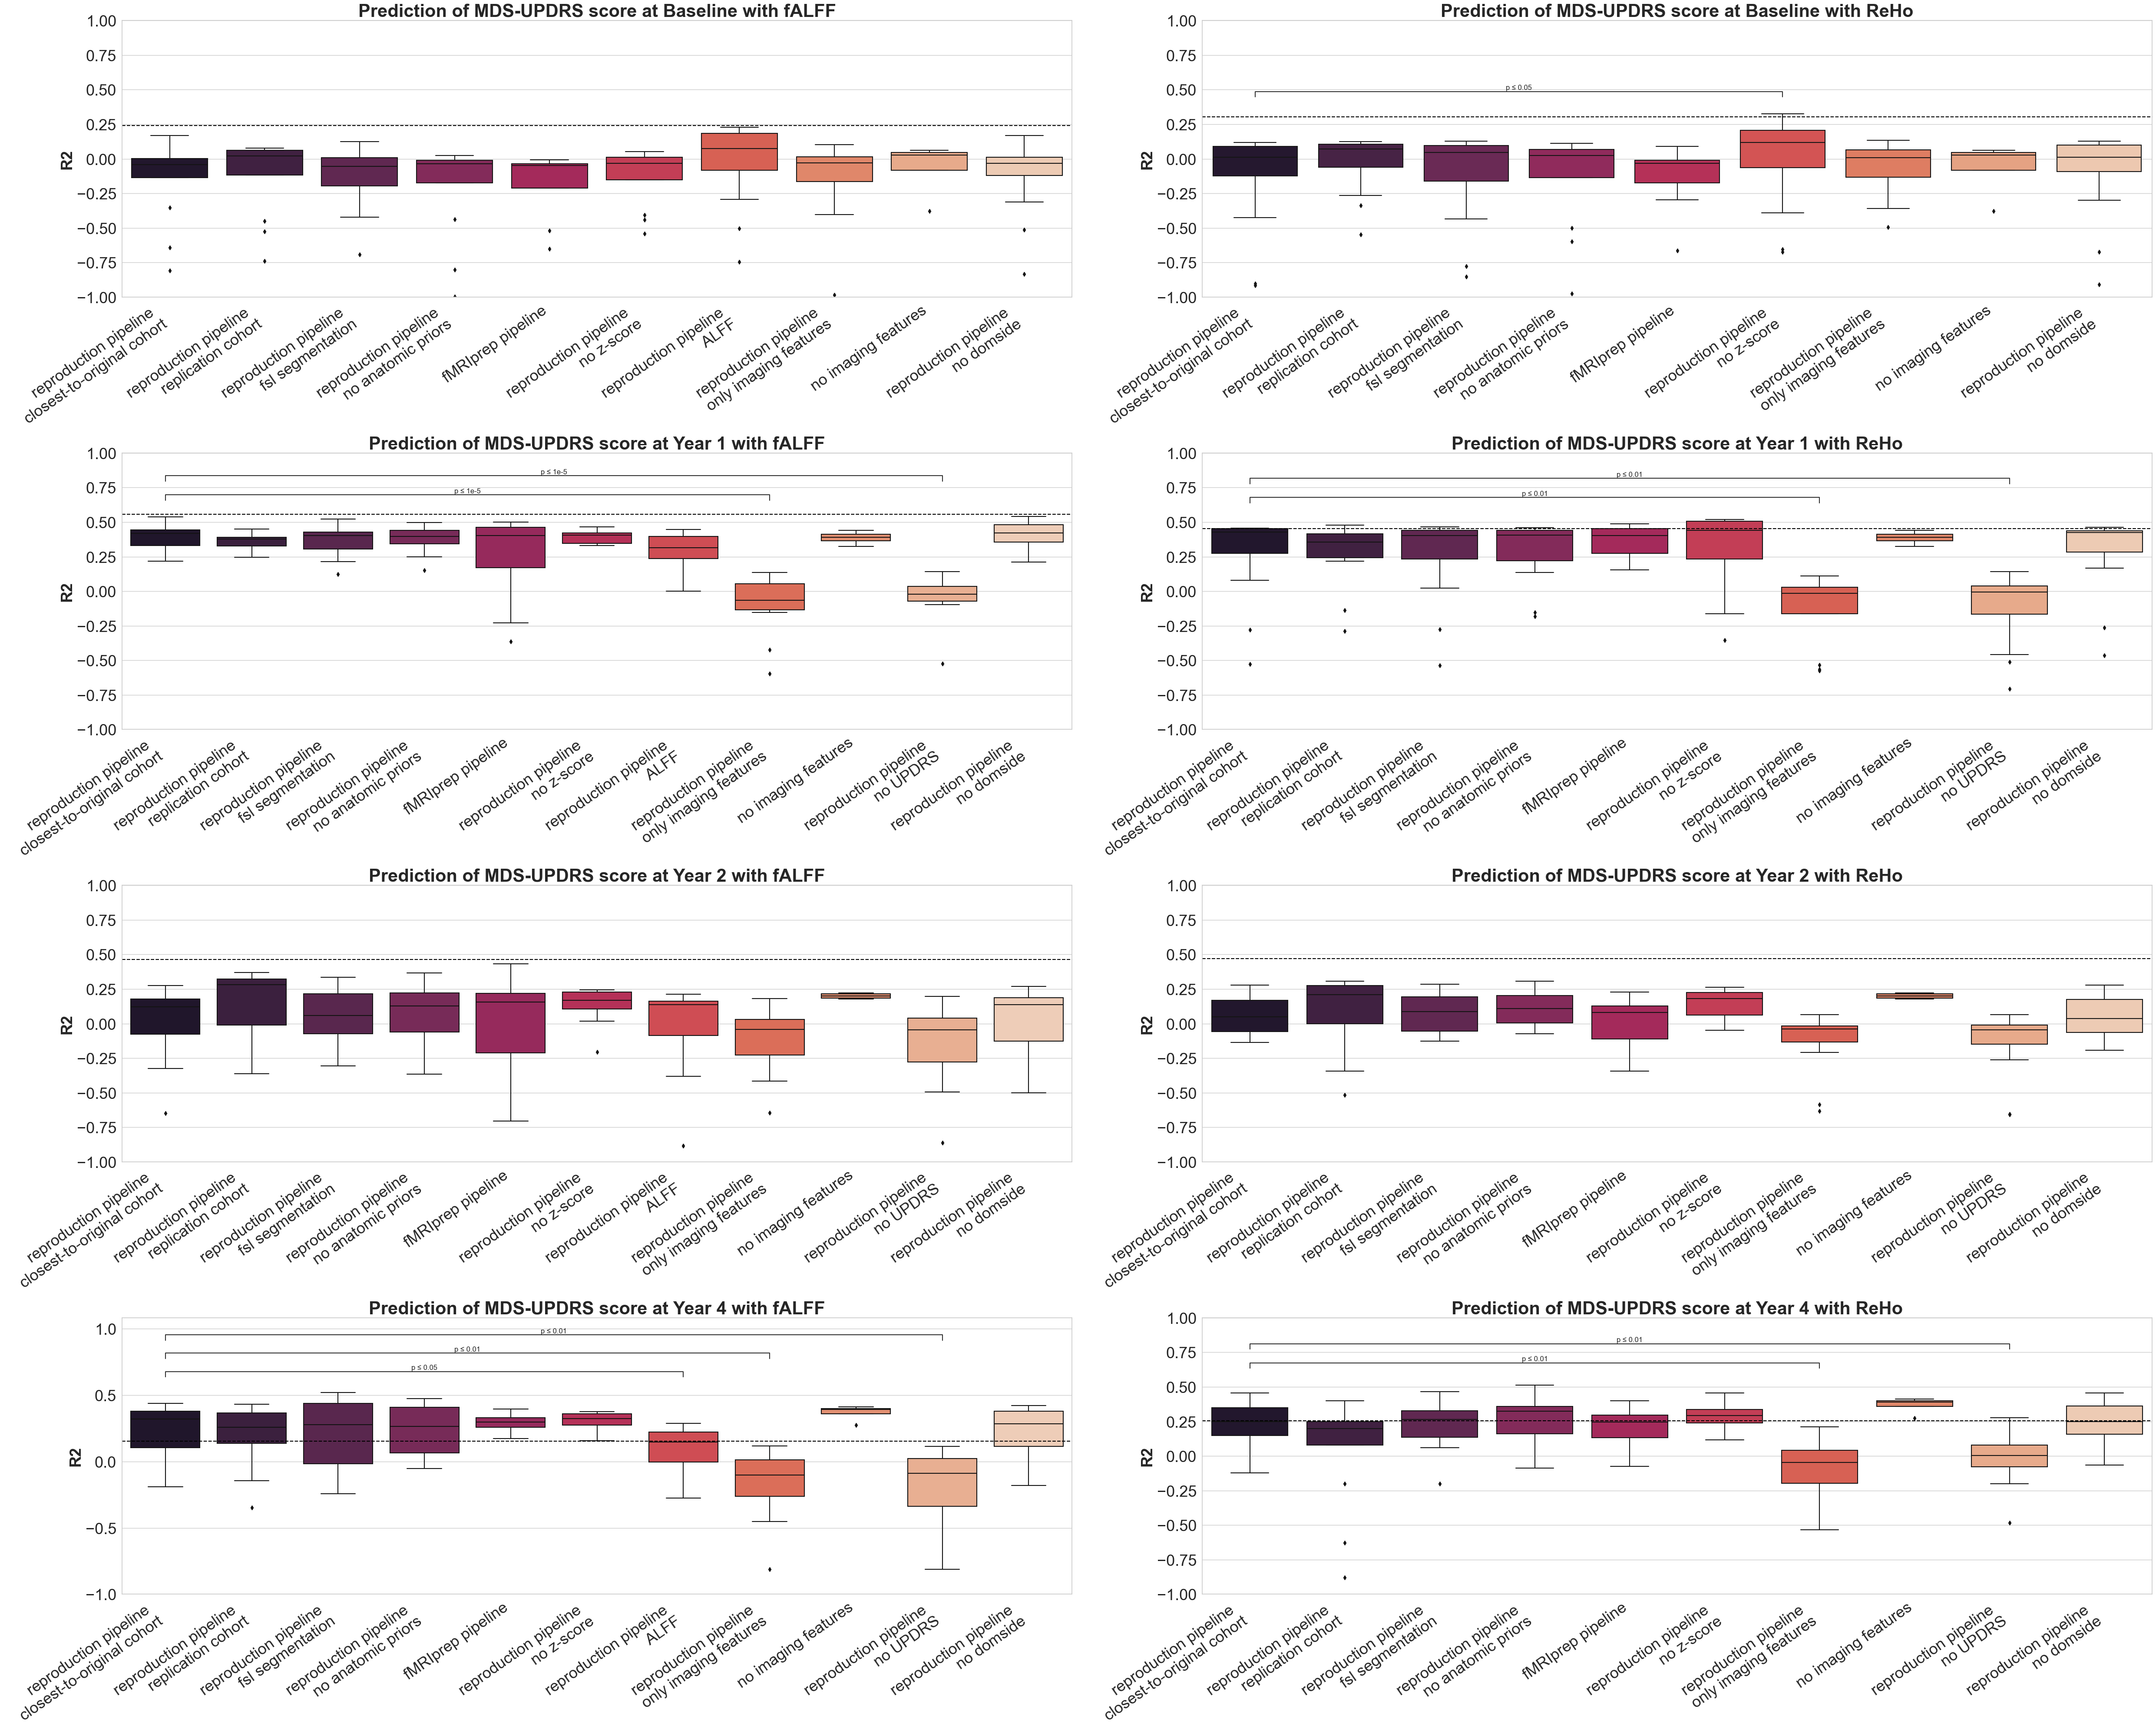

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statannotations.Annotator import Annotator

fig = plt.figure(figsize=(50,40))

i=0
for timepoint in ['Baseline', 'Year 1', 'Year 2', 'Year 4']:
    for feature in ['fALFF', 'ReHo']:
        pairs = []
        pval = []
        i+=1
        df = ml_summary_df.loc[(ml_summary_df['MDS-UPDRS Prediction target']==timepoint) &\
                                (ml_summary_df['Feature']==feature) &\
                                (ml_summary_df['Type']!='original')]

        for variations in np.unique(df['Type'].tolist()):
            if variations != 'original' and variations !='reproduction pipeline \n closest-to-original cohort':
                list_1 = ml_summary_df['R2'].loc[(ml_summary_df['MDS-UPDRS Prediction target']==timepoint) &\
                                        (ml_summary_df['Feature']==feature) &\
                                        (ml_summary_df['Type']=='reproduction pipeline \n closest-to-original cohort')].tolist()
                
                list_2 = ml_summary_df['R2'].loc[(ml_summary_df['MDS-UPDRS Prediction target']==timepoint) &\
                                        (ml_summary_df['Feature']==feature) &\
                                        (ml_summary_df['Type']==variations)].tolist()
                
                if mannwhitneyu(list_1, list_2)[1] < 0.05:
                    pairs.append(('reproduction pipeline \n closest-to-original cohort', variations))
                    pval.append(round(mannwhitneyu(list_1, list_2)[1],3))
                            
        if timepoint == 'Baseline':
            df = df.loc[~(df['Type'].isin(['only UPDRS'])) & ~(df['Type'].str.contains('no UPDRS'))]
        
        ax = fig.add_subplot(4,2,i)

        c = sns.boxplot(x=df['Type'], y=df['R2'], ax=ax, palette='rocket')
        
        c.tick_params(labelsize=26)
        plt.xticks(rotation=35, ha='right') 
        
        ax.set_title(f'Prediction of MDS-UPDRS score at {timepoint} with {feature}', fontsize=30, fontweight='bold')
        ax.set_ylim([-1,1])
        ax.set_ylabel('R2',fontsize=26, fontweight='bold')
        ax.set_xlabel('',fontsize=22)

        if len(pairs)>0:
            annotator = Annotator(pairs = pairs, ax=ax, data=df, x='Type', y='R2', palette='rocket')
            annotator.configure(text_format="simple")
            #annotator.configure(test='Mann-Whitney', verbose=True).apply_and_annotate()
            #annotator.set_custom_annotations([f'p={pvalue:.2e}' for pvalue in pval])
            annotator.set_pvalues(pval)
            annotator.annotate()

        y_original = ml_summary_df['R2'].loc[(ml_summary_df['MDS-UPDRS Prediction target']==timepoint) &\
                                (ml_summary_df['Feature']==feature) &\
                                (ml_summary_df['Type']=='original')].tolist()[0]
        ax.axhline(y = y_original, linestyle = "dashed", color='black') 
        
        
plt.tight_layout()
plt.savefig('./outputs/figure3-perf_comparison.png')

## Comparing cross-validation procedures

In [113]:
cv_dict_summary = {}

pipeline = 'reproduction_pipeline-afni_seg'
specific = None 

original_df = './images/original_results.csv'
cv_dict_summary['original'] = results.plot_results_table(pipeline, 
                                                      original_df_file = original_df, 
                                                      specific = specific, 
                                                      display='all')

cv_dict_summary['original'] = cv_dict_summary['original'].loc[(cv_dict_summary['original']['Type']=='Original')]

# Cohort comparison
pipeline = 'reproduction_pipeline-afni_seg'
specific = '_same'
cv_dict_summary['reproduction - best'] = results.plot_results_table(pipeline, 
                                                                                original_df_file = None, 
                                                                                specific = specific, 
                                                                                display='best')

pipeline = 'reproduction_pipeline-afni_seg'
specific = '_same'
cv_dict_summary['reproduction - nested cv'] = results.plot_results_table(pipeline, 
                                                                                original_df_file = None, 
                                                                                specific = specific, 
                                                                                display='folds')

pipeline = 'reproduction_pipeline-afni_seg'
specific = '_same'
cv_dict_summary['reproduction - same'] = results.plot_results_table(pipeline, 
                                                                                original_df_file = original_df, 
                                                                                specific = specific, 
                                                                                display='same')

cv_dict_summary['reproduction - same'] = cv_dict_summary['reproduction - same'].loc[(cv_dict_summary['reproduction - same']['Type']!='Original')]


cv_summary_df = pd.DataFrame()

for timepoint in ['Baseline', 'Year 1', 'Year 2', 'Year 4']:
    for feature in ['fALFF', 'ReHo']:
        for config, df in cv_dict_summary.items():
            df['Type']=config
            cv_summary_df = pd.concat([cv_summary_df, df.loc[(df['MDS-UPDRS Prediction target']==timepoint) &\
                  (df['Feature']==feature)]])

cv_summary_df.to_csv('./outputs/tab4-performance-nested_cv.csv')

In [118]:
cv_summary_df.set_index(['MDS-UPDRS Prediction target', 'Feature','Type'])

Best performing model  \
MDS-UPDRS Prediction target Feature Type                                             
Baseline                    fALFF   original                     Gradient Boosting   
                                    reproduction - best          Gradient Boosting   
                                    reproduction - nested cv     Gradient Boosting   
                                    reproduction - same          Gradient Boosting   
                            ReHo    original                     Gradient Boosting   
                                    reproduction - best                 ElasticNet   
                                    reproduction - nested cv            ElasticNet   
                                    reproduction - same          Gradient Boosting   
Year 1                      fALFF   original                            ElasticNet   
                                    reproduction - best          Gradient Boosting   
                                    reproduction - nested cv     Gradient Boosting   
                                    reproduction - same                 ElasticNet   
                            ReHo    original                            ElasticNet   
                                    reproduction - best              Random Forest   
                                    reproduction - nested cv         Random Forest   
                                    reproduction - same                 ElasticNet   
Year 2                      fALFF   original                            ElasticNet   
                                    reproduction - best              Random Forest   
                                    reproduction - nested cv         Random Forest   
                                    reproduction - same                 ElasticNet   
                            ReHo    original                            ElasticNet   
                                    reproduction - best                 ElasticNet   
                                    reproduction - nested cv            ElasticNet   
                                    reproduction - same                 ElasticNet   
Year 4                      fALFF   original                                   SVM   
                                    reproduction - best          Gradient Boosting   
                                    reproduction - nested cv     Gradient Boosting   
                                    reproduction - same                        SVM   
                            ReHo    original                                   SVM   
                                    reproduction - best                 ElasticNet   
                                    reproduction - nested cv            ElasticNet   
                                    reproduction - same                        SVM   

                                                             Best performing parcellation  \
MDS-UPDRS Prediction target Feature Type                                                    
Baseline                    fALFF   original                                     Schaefer   
                                    reproduction - best                           BASC197   
                                    reproduction - nested cv                      BASC197   
                                    reproduction - same                          Schaefer   
                            ReHo    original                                     Schaefer   
                                    reproduction - best                           BASC444   
                                    reproduction - nested cv                      BASC444   
                                    reproduction - same                          Schaefer   
Year 1                      fALFF   original                                     Schaefer   
                                    reproduction - best                           BASC444   
                    